# Clustering

Last access (y.m.d): 21.05.11  
Last update (y.m.d): 21.05.11   

This notebook will be used to cluster the data in terms of basic tuning properties and sfMix metrics of interest. The data source will be jointList*, which contains vital tuning properties for each cell in our experiment. 

### Table of contents

- Initialize  
- Regression
- Clustering
    - kmeans
    - agglomerative
- tSNE

# Initialize

In [406]:
import numpy as np
import os
import helper_fcns as hf
import scipy.stats as ss
from scipy.stats.mstats import gmean
from scipy.stats import ks_2samp, kstest, linregress

from sklearn.manifold import TSNE
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

import pandas as pd
import statsmodels.api as sm

import itertools
import autoreload
from IPython.core.display import display, HTML, Image

import pdb

import seaborn as sns
# plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
import matplotlib.cm as cm
import matplotlib.backends.backend_pdf as pltSave
%matplotlib inline
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');

In [407]:
# Before any plotting, fix plotting paramaters
plt.style.use('https://raw.githubusercontent.com/paul-levy/SF_diversity/master/paul_plt_style.mplstyle');
from matplotlib import rcParams
rcParams['font.size'] = 20;
rcParams['pdf.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                    
rcParams['ps.fonttype'] = 42 # should be 42, but there are kerning issues                                                                                                                                                                                                     

rcParams['lines.linewidth'] = 2.5;
rcParams['lines.markeredgewidth'] = 0; # no edge, since weird tings happen then
rcParams['axes.linewidth'] = 1.5;
rcParams['lines.markersize'] = 5;

rcParams['xtick.major.size'] = 15
rcParams['xtick.minor.size'] = 8
rcParams['ytick.major.size'] = 15
rcParams['ytick.minor.size'] = 8

rcParams['xtick.major.width'] = 5
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.width'] = 5
rcParams['ytick.minor.width'] = 2

rcParams['font.family'] = 'DejaVu Sans'
rcParams['font.style'] = 'oblique';
rcParams['font.size'] = 20;

In [408]:
base_dir = os.getcwd() + '/';

jl_suffix = 'V1_wMods_210509_vT70_dvT70'

# jointList_nm = 'jointList_V1full_200406.npy';
# jointList_nm = 'jointList_200414.npy';
# jointList_nm = 'jointList_200422_vT80_dvT80.npy';
# jointList_nm = 'jointList_V1_200609_vT70_dvT60.npy';
# jointList_nm = 'jointList_V1_200610_vT70_dvT60.npy';
jointList_nm = 'jointList_%s.npy' % jl_suffix

try:
    jointList = hf.np_smart_load('%s' % jointList_nm)
except:
    jointList = np.load('%s' % jointList_nm, allow_pickle=True);

In [409]:
### Trim the jointList on some criteria?
# A: must have at least one single grating tuning curve which has non-nan varExpl (i.e. > dogVarExplThresh) 
# --- for the diff-of-gauss tuning fit
prevCells = len(jointList)
critA = np.where([len(np.where(~np.isnan(jointList[x]['metrics']['dog_varExpl'][0,:]))[0]) > 0 for x in sorted(jointList.keys())])[0]

jointListTrim = {key: jointList[key] for key in critA}
jointList = jointListTrim

remCells = len(jointList)

nCut = prevCells-remCells

print('We cut %d cells (%.2f%% of the original %d)' % (nCut, 100*nCut/prevCells, prevCells))

We cut 31 cells (25.20% of the original 123)


In [410]:
saveName = 'figures/reports/clustering_%s/' % jl_suffix # for one save name for all figures
save_loc = base_dir + saveName;

# Regression

Let's start simple first. We can analyze tuning properties are correlated with one another, and which are correlated with the sfMix metrics we care about (for example, prefSF shift with contrast)

#### Unpack the core metrics

In [367]:
### NOTE: The following will be stored as log2 (ratios, frequency values)
# - f1f0 (ratio)
# - c50 (contrast viewed in log)
# - sfPref_basic (sf viewed in log2)
# - tfPref (tf viewed in log2)
# - mix_sfPref (sf measure)
# - mix_sf70 (sf measure)
# - mix_sf75 (sf measure)
# - mix_charFreq (sf measure)
# - gsf_data/mod (size in degrees)
# - mix_prefRatData (already in log2)
# - mix_psfModRat[Norm] (already in log2)
# - mix_prefRadData (already in log2)
# - mix_psfModRat[Norm] (already in log2)

nCells = len(jointList);

c50_basic = np.nan * np.zeros((nCells, ))
c50_eff_basic = np.copy(c50_basic);

f1f0 = np.copy(c50_basic)

supr_data = np.copy(c50_basic)
supr_mod = np.copy(c50_basic)
gsf_data = np.copy(c50_basic)
gsf_mod = np.copy(c50_basic)

sfPref_basic = np.copy(c50_basic)
sfBW_basic = np.copy(c50_basic)

tfPref = np.copy(c50_basic)
tfBW = np.copy(c50_basic)

oriPref = np.copy(c50_basic)
oriBW = np.copy(c50_basic)
oriCV = np.copy(c50_basic)
oriDS = np.copy(c50_basic)

mix_sfPref = np.copy(c50_basic)
mix_dog_sfPref = np.copy(c50_basic)
mix_sf70 = np.copy(c50_basic)
mix_dog_sf70 = np.copy(c50_basic)
mix_sf75 = np.copy(c50_basic)
mix_dog_sf75 = np.copy(c50_basic)
mix_c50 = np.copy(c50_basic)
mix_c50_eff = np.copy(c50_basic)
mix_bwHalf = np.copy(c50_basic)
mix_bw34 = np.copy(c50_basic)
mix_charFreq = np.copy(c50_basic)

mix_prefRatData = np.copy(c50_basic)
mix_bwHalfDiffData = np.copy(c50_basic)
mix_bw34DiffData = np.copy(c50_basic)
mix_sf70RatData = np.copy(c50_basic)
mix_dog_sf70RatData = np.copy(c50_basic)
mix_sf75RatData = np.copy(c50_basic)
mix_dog_sf75RatData = np.copy(c50_basic)

mix_psfModRat = np.copy(c50_basic)
mix_psfModRat_norm = np.copy(c50_basic)

mix_sf70ModRat= np.copy(c50_basic)
mix_sf70ModRat_norm = np.copy(c50_basic)

mix_dog_sf70ModRat = np.copy(c50_basic)
mix_dog_sf70ModRat_norm = np.copy(c50_basic)

mix_sf75ModRat= np.copy(c50_basic)
mix_sf75ModRat_norm = np.copy(c50_basic)

mix_dog_sf75ModRat = np.copy(c50_basic)
mix_dog_sf75ModRat_norm = np.copy(c50_basic)

for ind in np.arange(nCells):
    #########
    ### Basics (basic characterizations, f1f0)
    #########
    # f1/f0
    try:
        f1f0[ind] = np.log2(jointList[ind]['metrics']['f1f0_ratio']);
    except:
        pass
    # RF SIZE
    try: # suppression index from model fit (Cavanaugh '02, see hf.sizeTune for details)
        supr_data[ind] = jointList[ind]['basics']['rfsize']['suprInd_data']
    except:
        pass
    try: # suppression index from data (Cavanaugh '02, see hf.sizeTune for details)
        supr_mod[ind] = jointList[ind]['basics']['rfsize']['suprInd_model']
    except:
        pass
    try: # grating summation field from model fit (Cavanaugh '02, see hf.sizeTune for details)
        gsf_data[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_data'])
    except:
        pass
    try: # rating summation fieldfrom data (Cavanaugh '02, see hf.sizeTune for details)
        gsf_mod[ind] = np.log2(jointList[ind]['basics']['rfsize']['gsf_model'])
    except:
        pass
    # RVC
    try: # get c50
        c50_basic[ind] = np.log2(jointList[ind]['basics']['rvc']['c50'])
        c50_eff_basic[ind] = np.log2(jointList[ind]['basics']['rvc']['c50_eval'])
    except:
        pass
    # TF
    try: # get prefTF
        tfPref[ind] = np.log2(jointList[ind]['basics']['tf']['tfPref'])
    except:
        pass
    try: # get tfBW
        tfBW[ind] = jointList[ind]['basics']['tf']['tfBW_oct']
    except:
        pass
    # Orientation
    try: # get oriPref
        oriPref[ind] = jointList[ind]['basics']['ori']['pref']
    except:
        pass
    try: # get oriBW
        oriBW[ind] = jointList[ind]['basics']['ori']['bw']
    except:
        pass
    try: # get oriCV
        oriCV[ind] = jointList[ind]['basics']['ori']['cv']
    except:
        pass
    try: # get DS
        oriDS[ind] = jointList[ind]['basics']['ori']['DS']
    except:
        pass
    # SF tuning (from the sf1* series, not as measured in the sfMix experiment)
    try: # get prefSf
        sfPref_basic[ind] = np.log2(jointList[ind]['basics']['sf']['sfPref'])
    except:
        pass
    try: # get sfbw
        sfBW_basic[ind] = jointList[ind]['basics']['sf']['sfBW_oct']
    except:
        pass

    
    #########
    ### sfMixture metrics
    #########
    try: # prefSf
        mix_sfPref[ind] = np.log2(jointList[ind]['metrics']['pSf'][0,-1]);
        mix_dog_sfPref[ind] = np.log2(jointList[ind]['metrics']['dog_pSf'][0,-1]);
        mix_sf70[ind] = np.log2(jointList[ind]['metrics']['sf70'][0,-1]);
        mix_dog_sf70[ind] = np.log2(jointList[ind]['metrics']['dog_sf70'][0,-1]);
        mix_sf75[ind] = np.log2(jointList[ind]['metrics']['sf75'][0,-1]);
        mix_dog_sf75[ind] = np.log2(jointList[ind]['metrics']['dog_sf75'][0,-1]);
    except:
        pass
    try: # c50 at SF nearest to prefSF
        sf_vals = jointList[ind]['metadata']['stimVals'][2];
        if ~np.isnan(mix_sfPref[ind]):
            prefSfInd = np.argmin(np.square(np.power(2, mix_sfPref[ind]) - sf_vals));
        else:
            # what sf_val is closest to the "center of mass" for single grating, high con?
            prefSfInd = np.argmin(np.square(jointList[ind]['metrics']['sfCom'][0, -1] - sf_vals));
        mix_c50[ind] = np.log2(jointList[ind]['metrics']['c50'][0, prefSfInd]);
        mix_c50_eff[ind] = np.log2(jointList[ind]['metrics']['c50_eval'][0, prefSfInd]);
    except:
        pass
    try: # sfBW 1/2
        mix_bwHalf[ind] = jointList[ind]['metrics']['bwHalf'][0,-1];
    except:
        pass
    try: # sfBW 3/4
        mix_bw34[ind] = jointList[ind]['metrics']['bw34'][0,-1];
    except:
        pass
    try: # characteristic frequency
        mix_charFreq[ind] = np.log2(jointList[ind]['metrics']['dog_charFreq'][0,-1]);
    except:
        pass
    try:
        dispInd = 0; # evaluate this for single gratings
        # prefSf ratio 1:0.33 in data
        mix_prefRatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 2];
        # bwHalf ratio 1:0.33 in data
        mix_bwHalfDiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 0];
        # bw34 ratio 1:0.33 in data
        mix_bw34DiffData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 1];
        # 
        mix_sf70RatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 5];
        mix_dog_sf70RatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 6];
        mix_sf75RatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 7];
        mix_dog_sf75RatData[ind] = jointList[ind]['metrics']['diffsAtThirdCon'][dispInd, 8];
    except:
        pass
    try: # prefSfModRat, sf70ModRat, dog_sf70ModRat
        dispInd = 0; # evaluate this for single gratings
        # we fit a model to the prefSF as a function of contrast - the log2 ratio of that model at the highest/lowest valid contrast
        mix_psfModRat[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 0];
        # the same ratio normalized by the log contrast ratio of highest/lowest
        mix_psfModRat_norm[ind] = jointList[ind]['metrics']['pSfModRat'][dispInd, 1];

        mix_sf70ModRat[ind] = jointList[ind]['metrics']['sf70ModRat'][dispInd, 0];
        mix_sf70ModRat_norm[ind] = jointList[ind]['metrics']['sf70ModRat'][dispInd, 1];

        mix_dog_sf70ModRat[ind] = jointList[ind]['metrics']['dog_sf70ModRat'][dispInd, 0];
        mix_dog_sf70ModRat_norm[ind] = jointList[ind]['metrics']['dog_sf70ModRat'][dispInd, 1];

        mix_sf75ModRat[ind] = jointList[ind]['metrics']['sf75ModRat'][dispInd, 0];
        mix_sf75ModRat_norm[ind] = jointList[ind]['metrics']['sf75ModRat'][dispInd, 1];

        mix_dog_sf75ModRat[ind] = jointList[ind]['metrics']['dog_sf75ModRat'][dispInd, 0];
        mix_dog_sf75ModRat_norm[ind] = jointList[ind]['metrics']['dog_sf75ModRat'][dispInd, 1];
    except:
        pass

    
# smarter -- get lowest-possible contrast ratios
# -- this will return high, low in outputs [0], [1]
mix_prefRatData_low = np.log2(np.divide(*hf.jl_get_metric_highComp(jointList, 'pSf', 0, 1)[0:2]))
mix_bwHalfDiffData_low = np.subtract(*hf.jl_get_metric_highComp(jointList, 'bwHalf', 0, 1)[0:2])
mix_bw34DiffData_low = np.subtract(*hf.jl_get_metric_highComp(jointList, 'bw34', 0, 1)[0:2])
mix_sf70RatData_low = np.log2(np.divide(*hf.jl_get_metric_highComp(jointList, 'sf70', 0, 1)[0:2]))
# -- and for dog
mix_dog_prefRatData_low = np.log2(np.divide(*hf.jl_get_metric_highComp(jointList, 'dog_pSf', 1, 1)[0:2]))
mix_dog_bwHalfDiffData_low = np.subtract(*hf.jl_get_metric_highComp(jointList, 'dog_bwHalf', 1, 1)[0:2])
mix_dog_bw34DiffData_low = np.subtract(*hf.jl_get_metric_highComp(jointList, 'dog_bw34', 1, 1)[0:2])
mix_dog_sf70RatData_low = np.log2(np.divide(*hf.jl_get_metric_highComp(jointList, 'dog_sf70', 1, 1)[0:2]))

#### Quick aside for LGN-V1 modelling: what is the distribution of basic tuning parameters for simple cells in the newer datasets?

In [368]:
# excl_dir = 'V1_orig/'
# expInds = [x if excl_dir not in jointList[x]['metadata']['fullPath'] else np.nan for x in np.arange(len(jointList))]
# ok_inds = hf.nan_rm(np.array(expInds)).astype('int32')

In [369]:
# f1f0_pass = np.array([f1f0[x] for x in ok_inds])
# oriCV_pass = np.array([oriCV[x] for x in ok_inds])
# oriBW_pass = np.array([oriBW[x] for x in ok_inds])
# oriDS_pass = np.array([oriDS[x] for x in ok_inds])

# smp, cmp = np.where(f1f0_pass>0)[0], np.where(f1f0_pass<0)[0]
# inds = (smp, cmp);
# lbls = ('simple', 'complex');
# clrs = ('r', 'k');


# # oriCV
# cvBins = np.linspace(0, 1, 8);
# stepSize = (cvBins[-1] - cvBins[0])/(len(cvBins)-1);
# binPlotLocs = cvBins[1:] - 0.5*stepSize;
# clipLow, clipHigh = cvBins[1]-0.5*stepSize, cvBins[-2]+0.5*stepSize;
# curr_metric_clipped = np.clip(oriCV_pass, clipLow, clipHigh);
# tickVals = np.linspace(cvBins[1], cvBins[-2], len(cvBins)-2)

# counts = [np.histogram(curr_metric_clipped[x], cvBins)[0] for x in inds];
# mdns = [np.nanmedian(oriCV_pass[x]) for x in inds];
# # plt.bar(binPlotLocs, counts[0])
# [plt.bar(binPlotLocs, cnt, label=lbl, color=clr, width=stepSize*0.75, alpha=0.4) for cnt,lbl,clr in zip(counts, lbls, clrs)]
# plt.legend(fontsize='x-small')

# # oriBW
# oriBins = np.linspace(0, 200, 11);
# stepSize = (oriBins[-1] - oriBins[0])/(len(oriBins)-1);
# binPlotLocs = oriBins[1:] - 0.5*stepSize;
# clipLow, clipHigh = oriBins[1]-0.5*stepSize, oriBins[-2]+0.5*stepSize;
# curr_metric_clipped = np.clip(oriCV_pass, clipLow, clipHigh);
# tickVals = np.linspace(oriBins[1], oriBins[-2], len(oriBins)-2)

# counts = [np.histogram(curr_metric_clipped[x], oriBins)[0] for x in inds];
# mdns = [np.nanmedian(oriCV_pass[x]) for x in inds];
# # plt.bar(binPlotLocs, counts[0])
# [plt.bar(binPlotLocs, cnt, label=lbl, color=clr, width=stepSize*0.75, alpha=0.4) for cnt,lbl,clr in zip(counts, lbls, clrs)]
# plt.legend(fontsize='x-small')

### Unpack the sfMix metrics

In [370]:
supr_index = np.array([jointList[key]['superpos']['supr_index'] if jointList[key]['superpos'] is not None else np.nan for key in jointList.keys()])
corr_err = np.array([jointList[key]['superpos']['corr_derivWithErr'] if jointList[key]['superpos'] is not None else np.nan for key in jointList.keys()])
corr_errInd = np.array([jointList[key]['superpos']['corr_derivWithErrsInd'] if jointList[key]['superpos'] is not None else np.nan for key in jointList.keys()])
sfErrsInd_var = np.array([jointList[key]['superpos']['sfErrsInd_var'] if jointList[key]['superpos'] is not None else np.nan for key in jointList.keys()])
errsRat_var = np.array([jointList[key]['superpos']['errsRat_var'] if jointList[key]['superpos'] is not None else np.nan for key in jointList.keys()])


#### And get ready to "pack" everything

In [472]:
all_ind = np.vstack((f1f0, supr_data, supr_mod, gsf_mod, #gsf_data, c50_basic, #tfPref, tfBW, 
                     oriPref, oriBW, oriCV, oriDS, 
                     mix_c50, mix_c50_eff, # sfBW_basic, sfPref_basic, 
                     mix_sfPref, mix_sf70, mix_bwHalf)) # removed suprIndex
#                      mix_sfPref, mix_sf70, mix_dog_sfPref, mix_dog_sf70, mix_bwHalf, mix_bw34)) # removed suprIndex
all_dep = np.vstack((mix_bwHalfDiffData_low, mix_prefRatData_low, mix_sf70RatData_low,
                     mix_psfModRat, mix_psfModRat_norm))
# all_dep = np.vstack((mix_bwHalfDiffData_low, mix_bw34DiffData_low, mix_prefRatData_low, mix_sf70RatData_low,
#                      mix_dog_bwHalfDiffData_low, mix_dog_bw34DiffData_low, mix_dog_prefRatData_low, mix_dog_sf70RatData_low,
#                      mix_psfModRat, mix_psfModRat_norm))

all_ind_names = ['f1f0', 'supr_data', 'supr_mod', 'gsf_mod', #'gsf_data', #'c50_basic', #'tfPref', 'tfBW', 
                 'oriPref', 'oriBW', 'oriCV', 'oriDS', 
                 'mix_c50', 'mix_c50_eff', #'sfBW_basic', 'sfPref_basic', 
                 'mix_sfPref', 'mix_sf70', 'mix_bwHalf']; #, 'supr_index']
all_dep_names = ['mix_bwHalfDiffData_low', 'mix_prefRatData_low', 'mix_sf70RatData_low', 
                 'mix_psfModRat', 'mix_psfModRat_norm']
# some varialbles should be plotted log; these are those
all_ind_log_names = ['f1f0', 'gsf_mod', #'gsf_data', 'c50_basic', #'tfPref', 
                     'mix_c50', 'mix_c50_eff', #'sfPref_basic', 
                     'mix_sfPref', 'mix_sf70']
all_dep_log_names = ['mix_prefRatData_low', 'mix_sf70RatData_low',
                     'mix_psfModRat', 'mix_psfModRat_norm', 'errsRat_var']

## Before anything...
### What is the distribution of these sfMix metrics we care about?

##### For VSS, we're subsetting the data! ...or not?

In [473]:
# ### As of 21.03.30, SKIP

# v1alt_ok = np.array([1, 3, 4, 5, 6, 7]);
# v1_ok = np.array([1, 3, 5, 10, 11, 12, 14, 22, 23, 25, 28, 31, 35, 39, 40, 41, 43, 46, 47, 48, 51, 52, 53, 54]);

# max_V1_orig = 58;
# max_V1_alt = 8;
# v1alt_adj = max_V1_orig + v1alt_ok;
# v1_adj = max_V1_orig + max_V1_alt + v1_ok

# joint_adj = np.union1d(v1alt_adj, v1_adj)

##### Bandwidth

In [474]:
# ### BW-half, BW-34
# fBW, axBW = plt.subplots(2, 1, figsize=(15, 20), sharey=True)
# metrs = (mix_bwHalfDiffData, mix_bw34DiffData)
# labs = ('half-height', '3/4-height')

# fBW.suptitle('Contrast-dependent change in SF BW')

# for i in range(2):

#     curr_metric = metrs[i];
    
#     bins = np.linspace(-1, 2, 13);
#     stepSize = (bins[-1] - bins[0])/(len(bins)-1);
#     binPlotLocs = bins[1:] - 0.5*stepSize;
#     clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
#     curr_metric_clipped = np.clip(hf.nan_rm(curr_metric), clipLow, clipHigh);
#     tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
#     # - calculate
#     nCells = len(curr_metric_clipped);
#     medianBW = np.nanmedian(curr_metric);
#     mnBW = np.nanmean(curr_metric);
#     # - then plot!
#     vals, _ = np.histogram(curr_metric_clipped, bins=bins)
#     vals_norm = vals/np.sum(vals)
#     # -- hist
#     axBW[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
#     # -- median
#     axBW[i].plot(medianBW, 1.1*np.max(vals_norm), 'kv', markersize=15, label='median')
#     # -- no effect line
#     axBW[i].axvline(0, color='k', linestyle='--')
#     tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs[0] = '<%s' % tickStrs[0];
#     tickStrs[-1] = '>%s' % tickStrs[-1];
#     axBW[i].set_xticks(tickVals);
#     axBW[i].set_xticklabels(tickStrs, rotation=45);
#     axBW[i].set_xlabel('Octave difference (high-low)')
#     axBW[i].set_ylabel('frac. of cells');
#     axBW[i].set_title('%s (V1, n=%d, median=%.2f, mn=%.2f)' % (labs[i], nCells, medianBW, mnBW));
#     axBW[i].legend();
#     sns.despine(ax=axBW[i], offset=5)


# # now save
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + 'distr_sfBW_shift.pdf');
# pdfSv.savefig(fBW) # only one figure here...
# pdfSv.close()


##### Spatial frequency preference

In [475]:
# ### sfPref
# nRow = 3; nCol = 4;
# totNum = nRow*nCol;
# fSF, axSF = plt.subplots(nRow, nCol, figsize=(nCol*15, nRow*10), sharey=True)
# metrs = (mix_prefRatData, mix_psfModRat, mix_psfModRat_norm,
#         mix_sf70RatData, mix_sf70ModRat, mix_sf70ModRat_norm,
#         mix_dog_sf70RatData, mix_dog_sf70ModRat, mix_dog_sf70ModRat_norm,
#         mix_sf75RatData, mix_sf75ModRat, mix_sf75ModRat_norm);
# labs = ('prefRatio (1:0.33)', 'prefRatio (mod)', 'prefRatio (mod per log con.)',
#        'sf70Ratio (1:0.33)', 'sf70Ratio (mod)', 'sf70Ratio (mod per log con.)',
#        'dog_sf70Ratio (1:0.33)', 'dog_sf70Ratio (mod)', 'dog_sf70Ratio (mod per log con.)',
#        'sf75Ratio (1:0.33)', 'sf75Ratio (mod)', 'sf75Ratio (mod per log con.)')

# fSF.suptitle('Contrast-dependent change in preferred SF')

# for i in range(nRow):

#     for j in range(nCol):
        
#         ind_1d = np.ravel_multi_index(np.array([j,i]), (nCol,nRow))

#         curr_metric = metrs[ind_1d];

#         bins = np.linspace(-0.75, 0.75, 11);
#         stepSize = (bins[-1] - bins[0])/(len(bins)-1);
#         binPlotLocs = bins[1:] - 0.5*stepSize;
#         clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
#         curr_metric_clipped = np.clip(hf.nan_rm(curr_metric), clipLow, clipHigh);
#         tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
#         # - calculate
#         nCells = len(curr_metric_clipped);
#         medianBW = np.nanmedian(curr_metric);
#         mnBW = np.nanmean(curr_metric);
#         # - then plot!
#         vals, _ = np.histogram(curr_metric_clipped, bins=bins)
#         vals_norm = vals/np.sum(vals)
#         # -- hist
#         axSF[i,j].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
#         # -- median
#         axSF[i,j].plot(medianBW, 1.1*np.max(vals_norm), 'kv', markersize=15, label='median')
#         # -- no effect line
#         axSF[i,j].axvline(0, color='k', linestyle='--')
#         tickStrs = ['%.2f' % np.power(2, x) for x in tickVals];
#         tickStrs[0] = '<%s' % tickStrs[0];
#         tickStrs[-1] = '>%s' % tickStrs[-1];
#         axSF[i,j].set_xticks(tickVals);
#         axSF[i,j].set_xticklabels(tickStrs, rotation=45);
#         axSF[i,j].set_xlabel('Ratio (high/low)')
#         axSF[i,j].set_ylabel('frac. of cells');
#         axSF[i,j].set_title('%s (V1, n=%d, median=%.2f, mn=%.2f)' % (labs[ind_1d], nCells, medianBW, mnBW));
#         axSF[i,j].legend();
#         sns.despine(ax=axSF[i,j], offset=5)

# # now save
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + 'distr_sfPref_shift.pdf');
# pdfSv.savefig(fSF) # only one figure here...
# pdfSv.close()


##### Frequency-dependence of mixture suppression

In [476]:
# ### sfMix
# nRow = 4;
# fMix, axMix = plt.subplots(nRow, 1, figsize=(15, 10*nRow), sharey=True)
# metrs = (np.array(corr_err), np.array(corr_errInd), np.array(sfErrsInd_var), np.array(errsRat_var))
# labs = ('Corr. b/t mean signed error (MSE) and g\'', 'Corr. b/t ind MSE and g\'', 'sfErrsInd_var', 'Variance of suppression ratio')
# bin_ends = ([-1, 1], [-1, 1], [0, 0.1], [0, 0.7])
# plot_zero = (1, 1, 1, 0);

# fMix.suptitle('Frequency-dependence of mixture suppression')

# for (i, curr_metric), curr_lab, curr_bins, plt_zro in zip(enumerate(metrs), labs, bin_ends, plot_zero):
    
#     bins = np.linspace(curr_bins[0], curr_bins[1], 11);
#     stepSize = (bins[-1] - bins[0])/(len(bins)-1);
#     binPlotLocs = bins[1:] - 0.5*stepSize;
#     clipLow, clipHigh = bins[1]-0.5*stepSize, bins[-2]+0.5*stepSize;
#     curr_metric_clipped = np.clip(hf.nan_rm(curr_metric), clipLow, clipHigh);
#     tickVals = np.linspace(bins[1], bins[-2], len(bins)-2)
#     # - calculate
#     nCells = len(curr_metric_clipped);
#     medianBW = np.nanmedian(curr_metric);
#     mnBW = np.nanmean(curr_metric);
#     # - then plot!
#     vals, _ = np.histogram(curr_metric_clipped, bins=bins)
#     vals_norm = vals/np.sum(vals)
#     # -- hist
#     axMix[i].bar(binPlotLocs, vals_norm, width=0.8*stepSize, align='center', color='k');
#     # -- median
#     axMix[i].plot(medianBW, 1.1*np.max(vals_norm), 'kv', markersize=15, label='median')
#     if plt_zro == 1:
#         # -- no effect line
#         axMix[i].axvline(0, color='k', linestyle='--')
#     tickStrs = ['%.2f' % x for x in tickVals];
#     tickStrs[0] = '<%s' % tickStrs[0];
#     tickStrs[-1] = '>%s' % tickStrs[-1];
#     axMix[i].set_xticks(tickVals);
#     axMix[i].set_xticklabels(tickStrs, rotation=45);
#     axMix[i].set_xlabel('Magnitude...')
#     axMix[i].set_ylabel('frac. of cells');
#     axMix[i].set_title('%s (V1, n=%d, median=%.3f, mn=%.3f)' % (curr_lab, nCells, medianBW, mnBW));
#     axMix[i].legend();
#     sns.despine(ax=axMix[i], offset=5)
    
    
# # now save
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + 'distr_sfMix.pdf');
# pdfSv.savefig(fMix) # only one figure here...
# pdfSv.close()

### Zeroth, correlations


#### First,  within the independent variables (i.e. tuning properties that we think might be predictive)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  if sys.path[0] == '':


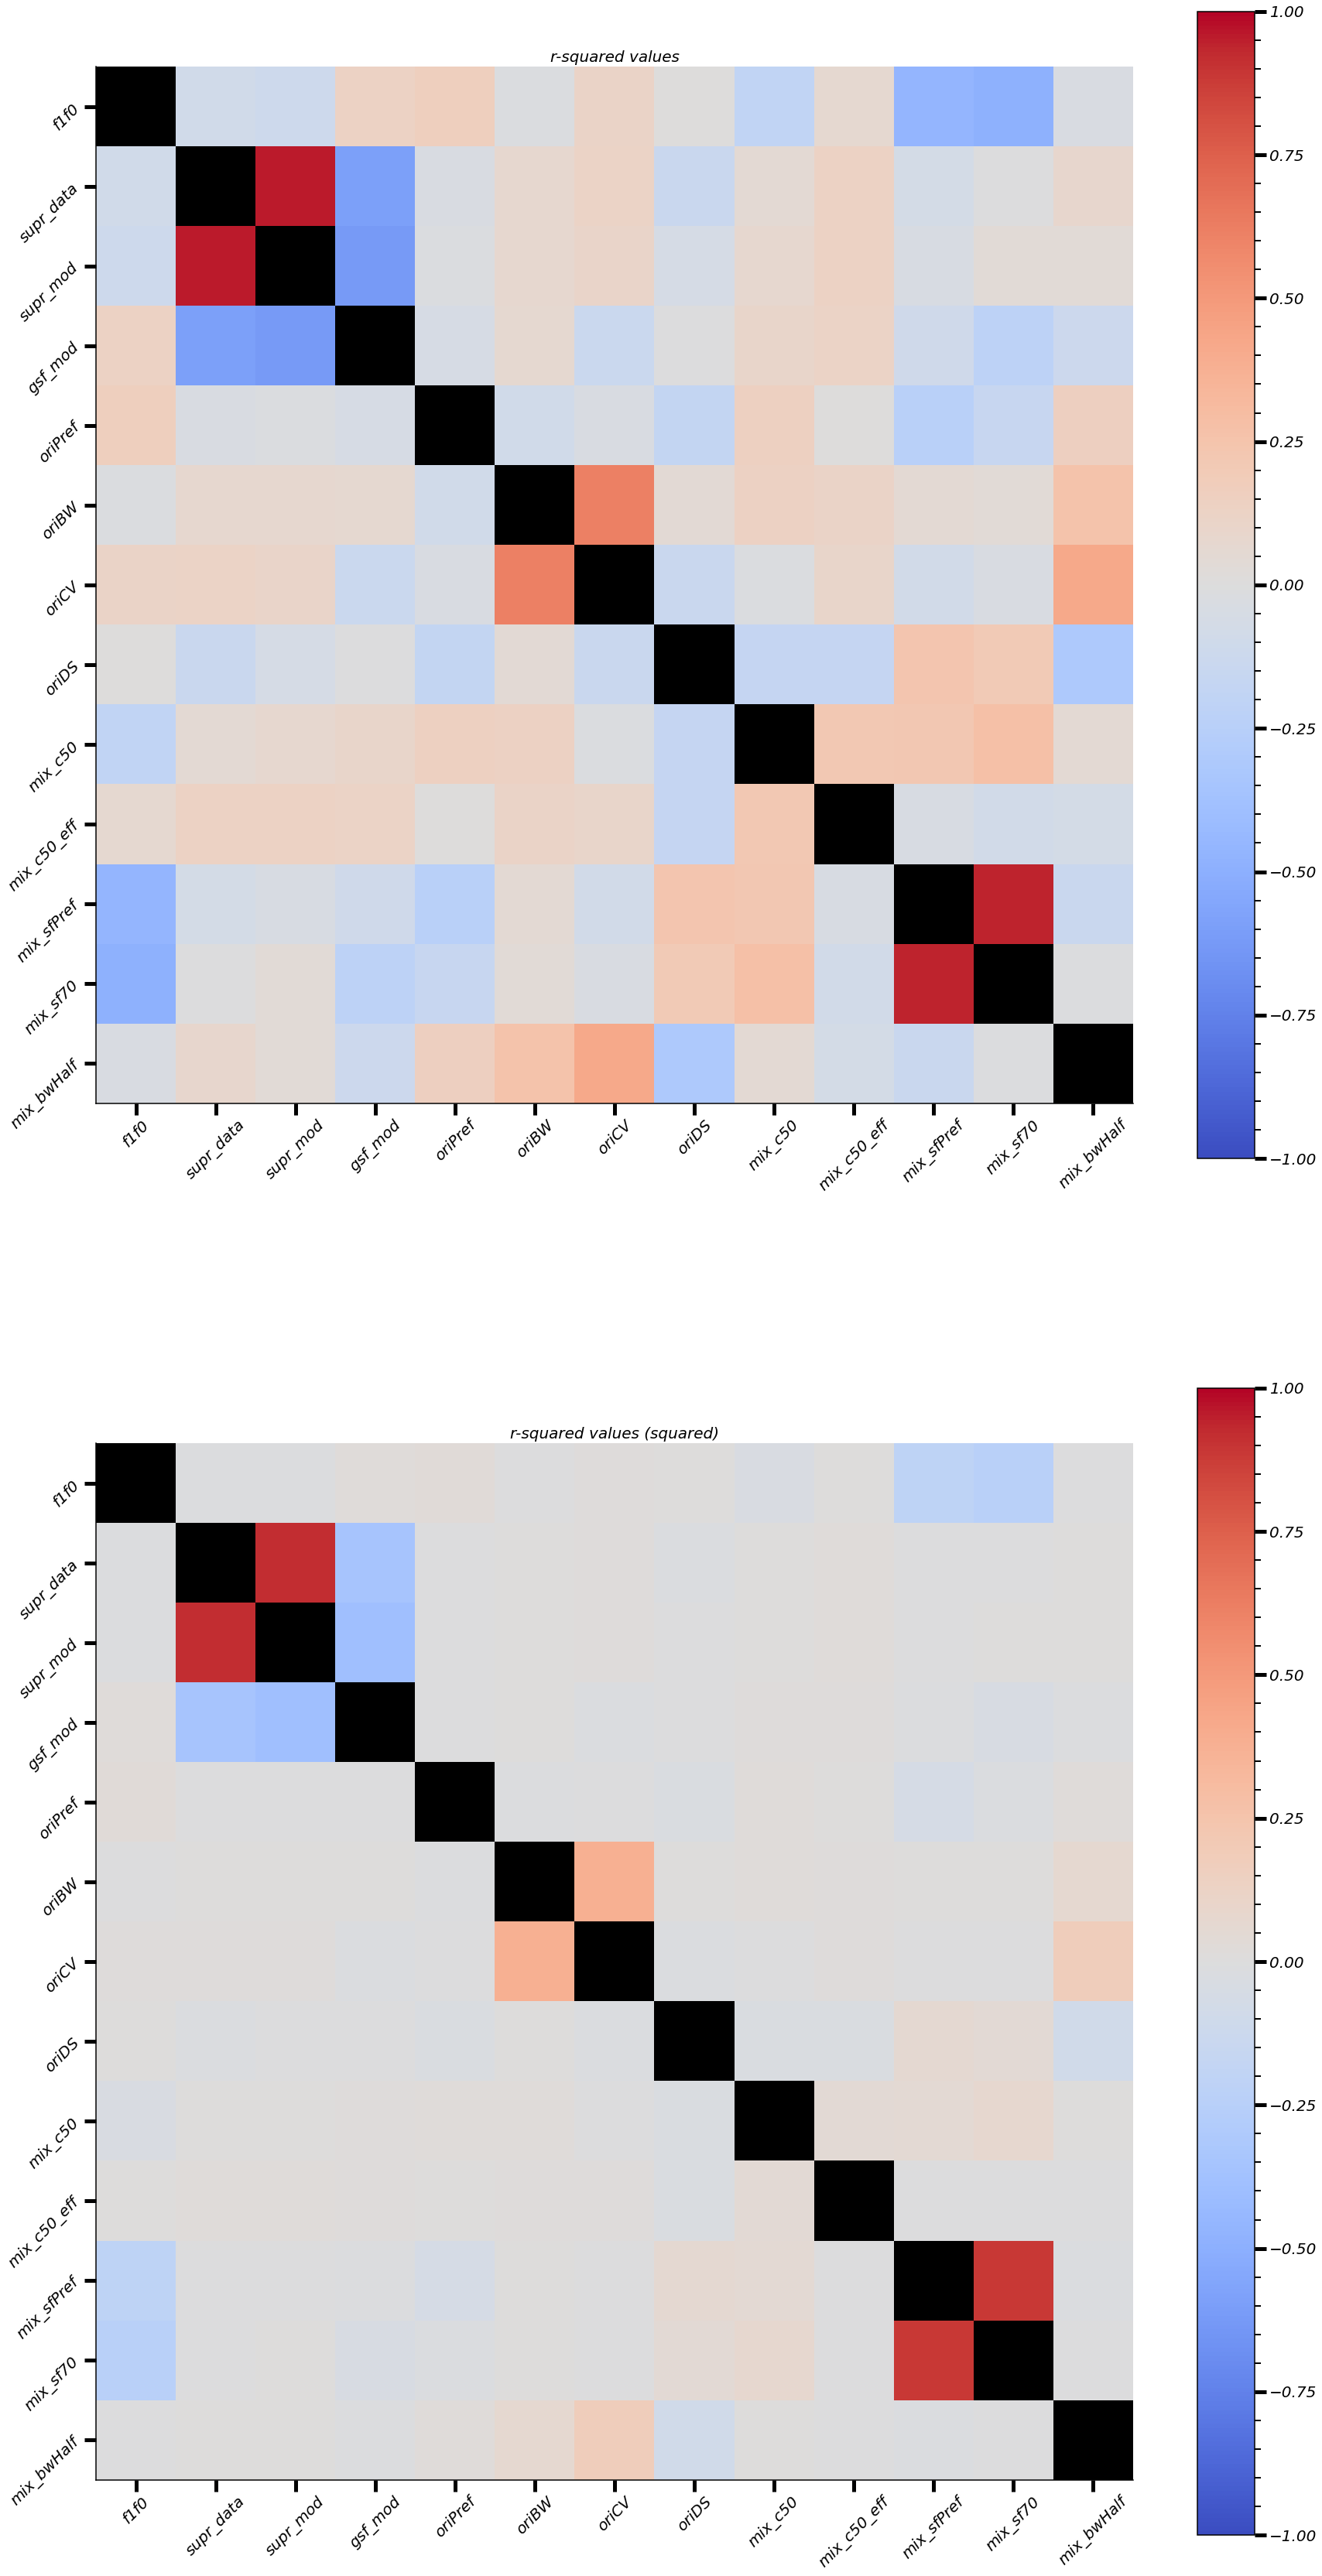

In [477]:
df = pd.DataFrame(all_ind.transpose(), columns=all_ind_names)

f, ax = plt.subplots(2, 1, figsize=(30, 2*30));

for i in range(2):
    plt.sca(ax[i])
    
    corrs = np.array(df.corr());
    xdiag, ydiag = np.diag_indices_from(corrs)
    corrs[xdiag, ydiag] = np.nan;
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(corrs)*np.square(corrs), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(corrs, cmap=cmp, vmin=-1, vmax=1);
    plt.xticks(np.arange(len(all_ind_names)), all_ind_names, rotation=45);
    plt.yticks(np.arange(len(all_ind_names)), all_ind_names, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')

        
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + 'regr_indVars.pdf');
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

The top plot is the "raw" r-squared values; the bottom plot are the same values squared - but with sign preserved - to see more easily the larger magnitude values. 

First, there are the "obvious" correlations:
- **supr_mod w/ supr_data** (suppression index; the model is fit to the same data used to derive the data measure)
- **gsf_mod w/ gsf_data** (same as above)
- **supr w/ gsf**: if there is minimal suppression, gsf will be large; if suppression is strong, gsf will be small
- **mix_bwHalf/bw34**: same measure of SF tuning width, determined at half-height or 3/4 height
- **mix_charFreq/mix_sfPref**: both are measures of SF preference (one is peak, one is high-frequency cut-off)

What do we know:
- oriBW and sfBW are positive correlated (Xing et al '04; DeValois et al '82)
- 

Now, what should be investigated?:
- **f1/f0 w/ charFreq or sfPref** 
- **c50 w/charFreq** 
- **oriDS w/ sfBW**: 
- ****: 
- ****:

#### Then,  within the *de*pendent variables (i.e. response measures we want to explain)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  if sys.path[0] == '':


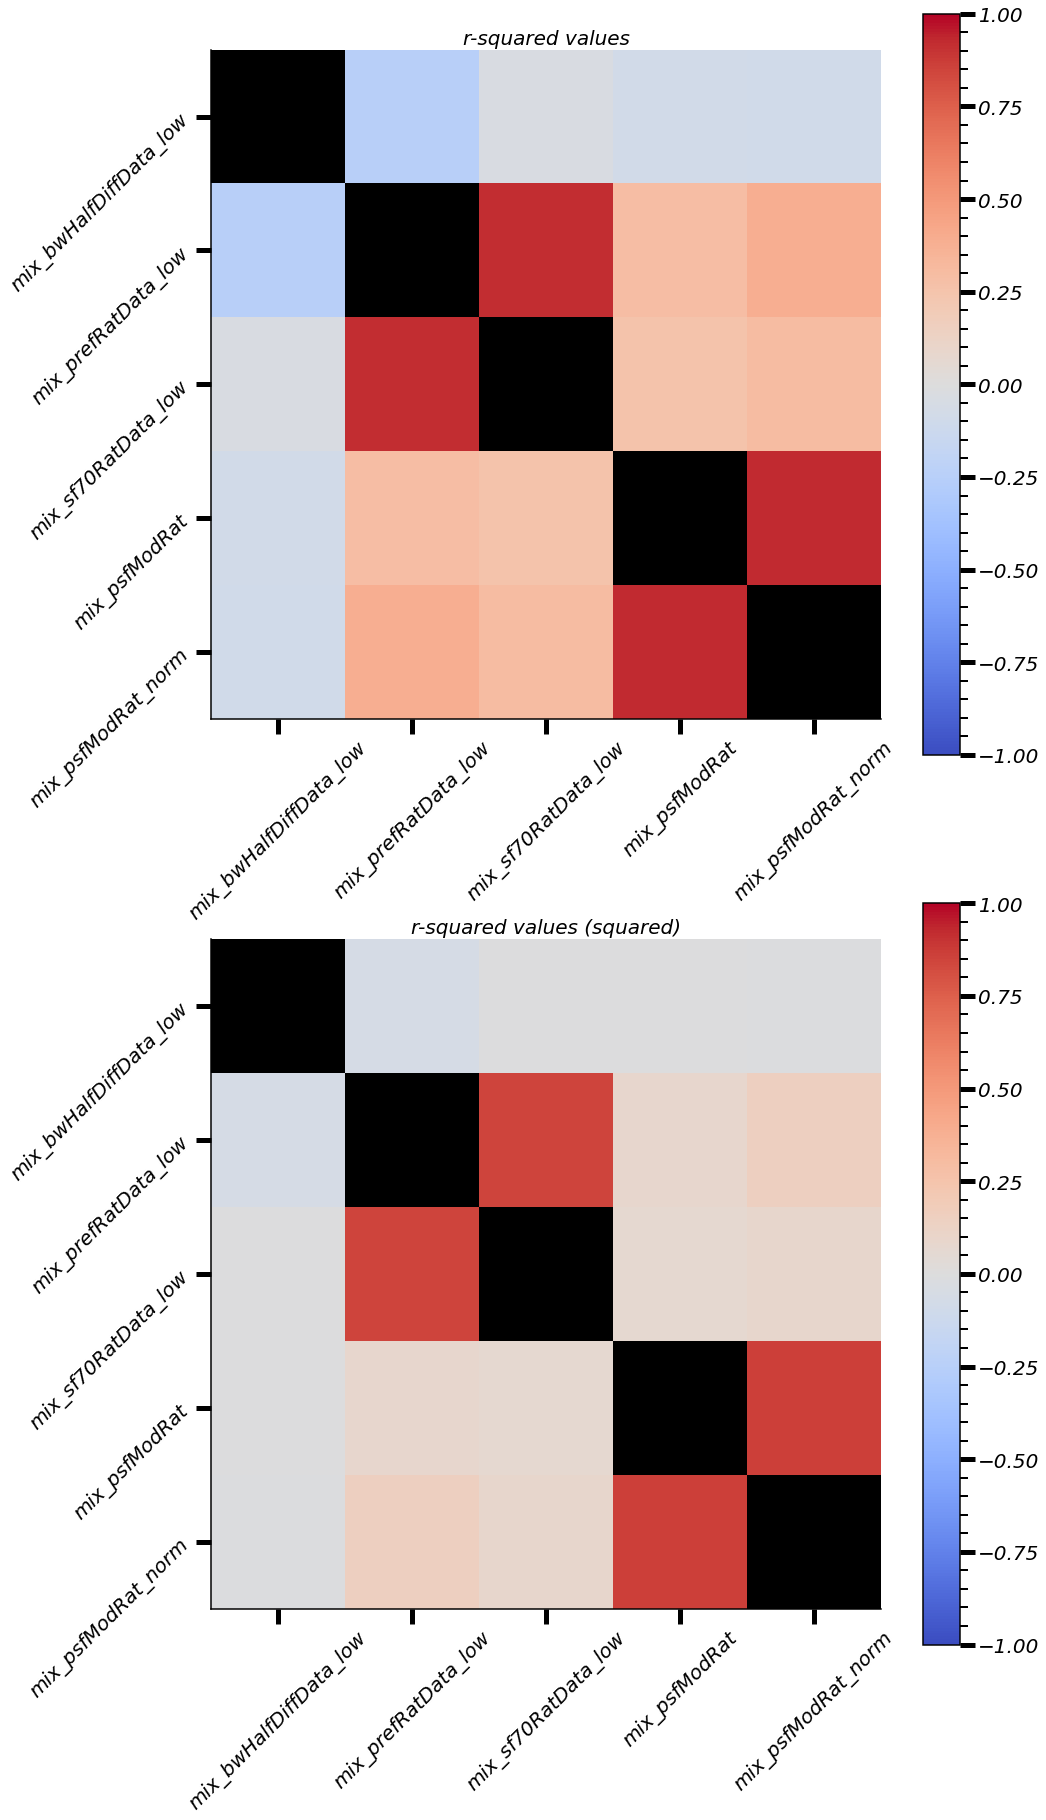

In [478]:
df = pd.DataFrame(all_dep.transpose(), columns=all_dep_names)

f, ax = plt.subplots(2, 1, figsize=(15, 2*15));

for i in range(2):
    plt.sca(ax[i])
    
    corrs = np.array(df.corr());
    xdiag, ydiag = np.diag_indices_from(corrs)
    corrs[xdiag, ydiag] = np.nan;
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(corrs)*np.square(corrs), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(corrs, cmap=cmp, vmin=-1, vmax=1);
    plt.xticks(np.arange(len(all_dep_names)), all_dep_names, rotation=45);
    plt.yticks(np.arange(len(all_dep_names)), all_dep_names, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')

        
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + 'regr_depVars.pdf');
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

Let's plot some example correlations between these variables...

In [479]:
all_dep_names

['mix_bwHalfDiffData_low',
 'mix_prefRatData_low',
 'mix_sf70RatData_low',
 'mix_psfModRat',
 'mix_psfModRat_norm']

In [378]:
# key1, key2 = 2,7;
# kys = (key1, key2)
# vals1, vals2 = [all_dep[k, :] for k in kys]
# ok_inds = np.logical_and(~np.isnan(vals1), ~np.isnan(vals2))
# nm1, nm2 = [all_dep_names[k] for k in kys]

# # correlation...
# model = sm.OLS(endog=vals2[ok_inds], exog=sm.tools.add_constant(vals1[ok_inds]), missing='drop', hasconst=True).fit()

# f = plt.figure(figsize=(10, 6))

# plt.scatter(vals1[ok_inds], vals2[ok_inds], c='k', s=50);
# plt.xlabel('%s' % nm1);
# plt.ylabel('%s' % nm2);
# to_eval = np.linspace(np.min(vals1[ok_inds]), np.max(vals1[ok_inds]), 100)
# mod_eval = model.predict(sm.tools.add_constant(to_eval))
# plt.plot(to_eval, mod_eval, 'r--');
# rsq, pval = model.rsquared, model.pvalues[0]
# plt.title('r = %.2f, p=%.2f, n=%d' % (rsq, pval, len(np.where(ok_inds)[0])));

# # now save
# if not os.path.exists(save_loc):
#     os.makedirs(save_loc)
# pdfSv = pltSave.PdfPages(save_loc + 'dep_corr_prefRat_errs_auc.pdf');
# pdfSv.savefig(f) # only one figure here...
# pdfSv.close()

## One-by-one correlation

In [480]:
n_deps = all_dep.shape[0];
n_inds = all_ind.shape[0];

all_reg_1d = dict();

for i_dep in np.arange(n_deps): # for each dependent variable
    for i_ind in np.arange(n_inds): # consider the correlation with each of the independent variables
        all_reg_1d[(i_dep, i_ind)] = dict();
        
        try:
            model = sm.OLS(endog=all_dep[i_dep, :], exog=sm.tools.add_constant(all_ind[i_ind, :]), missing='drop', hasconst=True).fit()
        
            # Print out the statistics
            all_reg_1d[(i_dep, i_ind)]['model'] = model;
            all_reg_1d[(i_dep, i_ind)]['n_cells'] = int(model.nobs)
            all_reg_1d[(i_dep, i_ind)]['rsquare'] = model.rsquared;
            all_reg_1d[(i_dep, i_ind)]['ind_name'] = all_ind_names[i_ind]
            all_reg_1d[(i_dep, i_ind)]['dep_name'] = all_dep_names[i_dep]
            all_reg_1d[(i_dep, i_ind)]['pval'] = model.pvalues[0]; # there's only one pvalue, here
        except:
            all_reg_1d[(i_dep, i_ind)]['model'] = None;
            all_reg_1d[(i_dep, i_ind)]['n_cells'] = np.nan
            all_reg_1d[(i_dep, i_ind)]['rsquare'] = -np.Inf
            all_reg_1d[(i_dep, i_ind)]['ind_name'] = all_ind_names[i_ind]
            all_reg_1d[(i_dep, i_ind)]['dep_name'] = all_dep_names[i_dep]
            all_reg_1d[(i_dep, i_ind)]['pval'] = -np.Inf;

In [481]:
all_keys = list(all_reg_1d)

r_vals = np.array([all_reg_1d[k]['rsquare'] for k in all_keys])
p_vals = np.array([all_reg_1d[k]['pval'] for k in all_keys])

In [482]:
lt_p05 = np.where(p_vals < 0.05)[0];
lt_keys = [all_keys[k] for k in lt_p05];

ind_lt05 = np.array([all_reg_1d[k]['ind_name'] for k in lt_keys])
unique_inds = np.unique(ind_lt05);
count_unique = np.array([np.sum(np.in1d(ind_lt05, k)) for k in unique_inds])
order_counts = np.argsort(count_unique)
ordered_names = unique_inds[order_counts];

print('Most *useful* dependent variables:')
['%s: %d' % (nm, ct) for nm,ct in zip(ordered_names, count_unique[order_counts])]

Most *useful* dependent variables:


['mix_sf70: 1',
 'oriBW: 1',
 'mix_c50: 2',
 'mix_sfPref: 2',
 'oriDS: 2',
 'f1f0: 3',
 'mix_c50_eff: 3',
 'gsf_mod: 4',
 'supr_data: 4',
 'supr_mod: 4']

In [483]:
dep_lt05 = np.array([all_reg_1d[k]['dep_name'] for k in lt_keys])
unique_inds = np.unique(dep_lt05);
count_unique = np.array([np.sum(np.in1d(dep_lt05, k)) for k in unique_inds])
order_counts = np.argsort(count_unique)
ordered_names = unique_inds[order_counts];

print('Most *explained* independent variables:')

['%s: %d' % (nm, ct) for nm,ct in zip(ordered_names, count_unique[order_counts])]

Most *explained* independent variables:


['mix_psfModRat: 4',
 'mix_psfModRat_norm: 4',
 'mix_bwHalfDiffData_low: 5',
 'mix_prefRatData_low: 6',
 'mix_sf70RatData_low: 7']

### Let's plot the "heat" map of correlations:

In [484]:
rsq = np.array([all_reg_1d[k]['rsquare'] for k in all_keys])
rsq_shape = np.reshape(rsq, (n_deps, n_inds));
rsq_df = pd.DataFrame(rsq_shape, columns=all_ind_names, index=all_dep_names)

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  


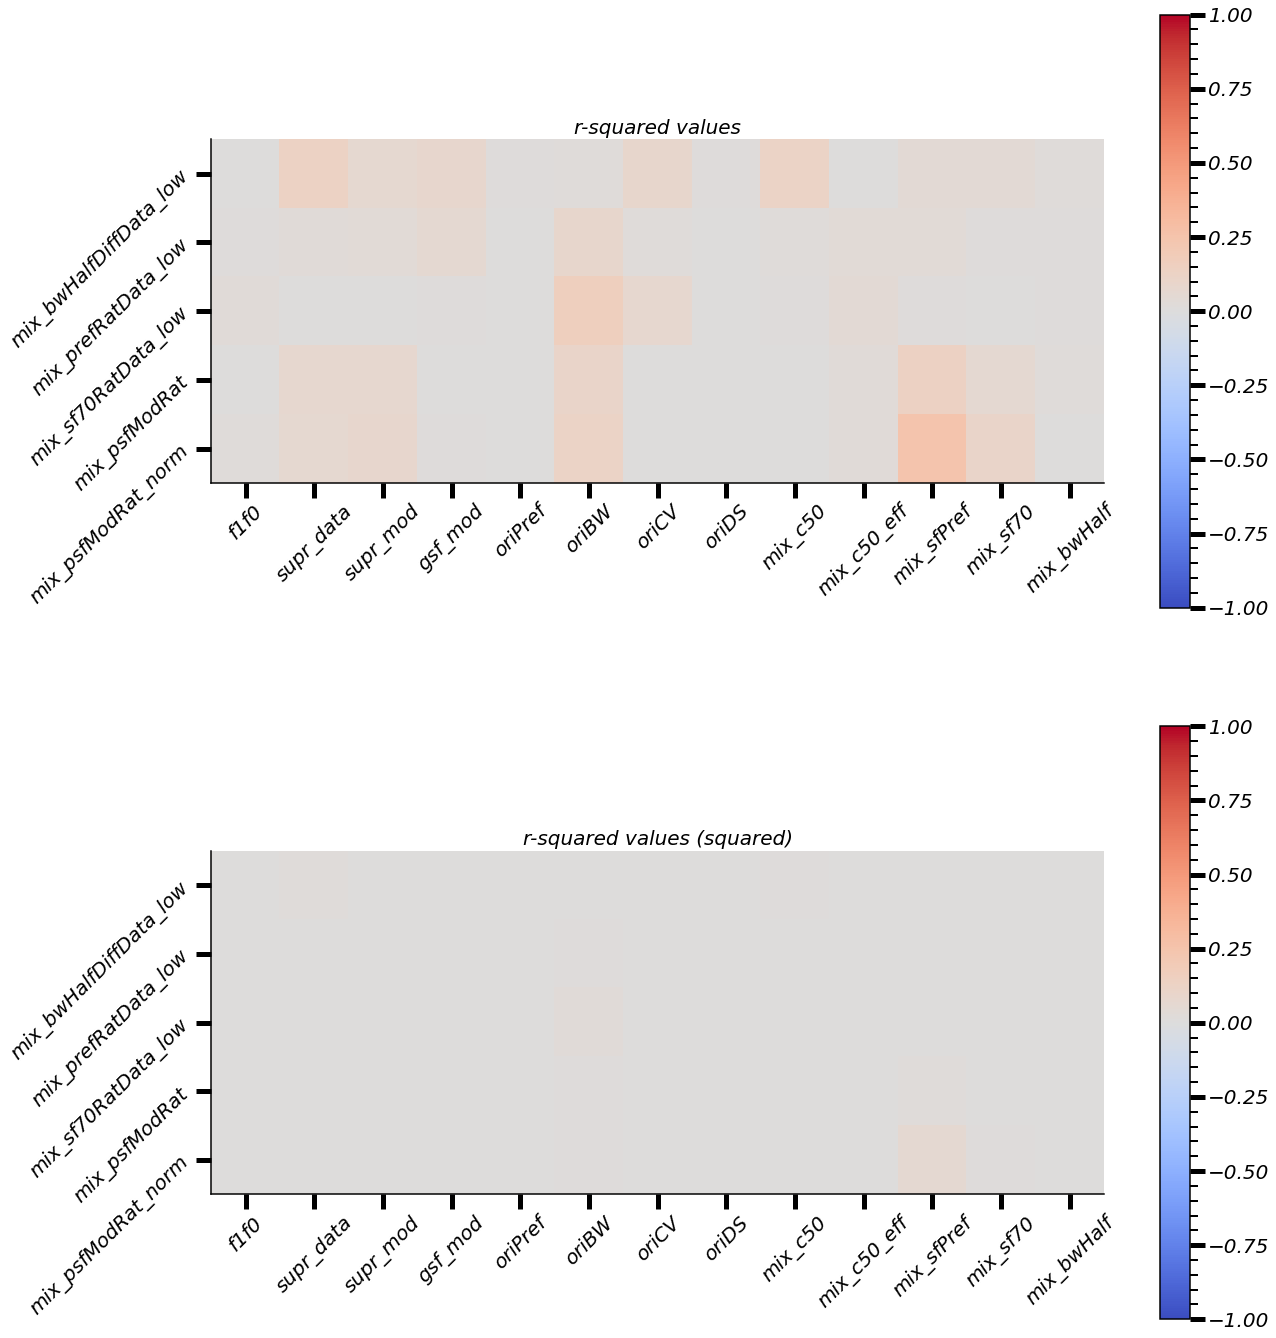

In [485]:
f, ax = plt.subplots(2, 1, figsize=(20, 2*12));


for i in range(2):
    plt.sca(ax[i])
    
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(rsq_df.values)*np.square(rsq_df.values), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(rsq_df.values, cmap=cmp, vmin=-1, vmax=1);
    plt.yticks(np.arange(n_deps), all_dep_names, rotation=45);
    plt.xticks(np.arange(n_inds), all_ind_names, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')

# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + 'regr_OneToOne.pdf');
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

In [486]:
# of interest:
# all_reg_1d[7, 17] (rInd=13)

In [488]:
whichOrder = 'P' # order the top N by "R" or "P"? ADJUST below, accordingly
topN = 25

for ind in np.arange(topN):

    if whichOrder == 'R':
        ### Sort in terms of R-value
        max_r = np.array(list(reversed(np.argsort(r_vals))))
        curr_key = all_keys[max_r[ind]];
    elif whichOrder == 'P':
        ### Sort in terms of P-value
        max_p = np.array(list(np.argsort(p_vals)))
        curr_key = all_keys[max_p[ind]];

    curr_mod = all_reg_1d[curr_key];
    r_val, p_val, n_cells = curr_mod['rsquare'], curr_mod['pval'], curr_mod['n_cells']
    ind_name, dep_name = curr_mod['ind_name'], curr_mod['dep_name'];
    title = '%s --> %s (rSq=%.2f, p=%.2e, n=%d)' % (ind_name, dep_name, r_val, p_val, n_cells)

    x_vals = all_ind[curr_key[1], :];
    y_vals = all_dep[curr_key[0], :];

    val_inds = np.logical_and(~np.isnan(x_vals), ~np.isnan(y_vals));

    if len(np.where(val_inds)[0]) < 2:
        continue;
    
    to_eval = np.linspace(np.min(x_vals[val_inds]), np.max(x_vals[val_inds]), 100)
    mod_eval = curr_mod['model'].predict(sm.tools.add_constant(to_eval))

    fCr = plt.figure(figsize=(12, 10))

    if np.in1d(ind_name, all_ind_log_names):
        x_vals = np.power(2, x_vals);

        plt.xscale('log')
    #     plt.xlim([np.round(np.nanmin(x_vals), decimals=1), np.round(np.nanmax(x_vals), decimals=0)])
        # plot the regression model
        plt.plot(np.power(2, to_eval), mod_eval, 'r--')
    else:
        # plot the regression model
        plt.plot(to_eval, mod_eval, 'r--')

    # plot the data
    plt.plot(x_vals[val_inds], y_vals[val_inds], 'ko', alpha=0.6, markersize=12, clip_on=False);

    plt.xlabel('%s' % ind_name);
    plt.ylabel('%s' % dep_name);
    plt.title(title);
    sns.despine(offset=10);

    # now save
    save_loc_temp = save_loc + 'regr_by%s_top%d/' % (whichOrder, topN)
    if not os.path.exists(save_loc_temp):
        os.makedirs(save_loc_temp)
    pdfSv = pltSave.PdfPages(save_loc_temp + 'regr_ex_%s_%s.pdf' % (ind_name, dep_name));
    pdfSv.savefig(fCr) # only one figure here...
    pdfSv.close()
    plt.close(fCr)

#### Now, let's have a section to plot specific regressions

In [388]:
print('Dependent variables:')
[print('%d: %s' %(i,s)) for i,s in enumerate(all_dep_names)];

print('\nIndependent variables:')
[print('%d: %s' %(i,s)) for i,s in enumerate(all_ind_names)];

Dependent variables:
0: mix_bwHalfDiffData
1: mix_prefRatData
2: mix_sf70RatData
3: mix_psfModRat
4: mix_psfModRat_norm

Independent variables:
0: f1f0
1: supr_data
2: supr_mod
3: gsf_mod
4: oriPref
5: oriBW
6: oriCV
7: oriDS
8: mix_c50
9: mix_c50_eff
10: mix_sfPref
11: mix_sf70
12: mix_bwHalf


_Note that keys are organized as (i_dep, i_ind)_

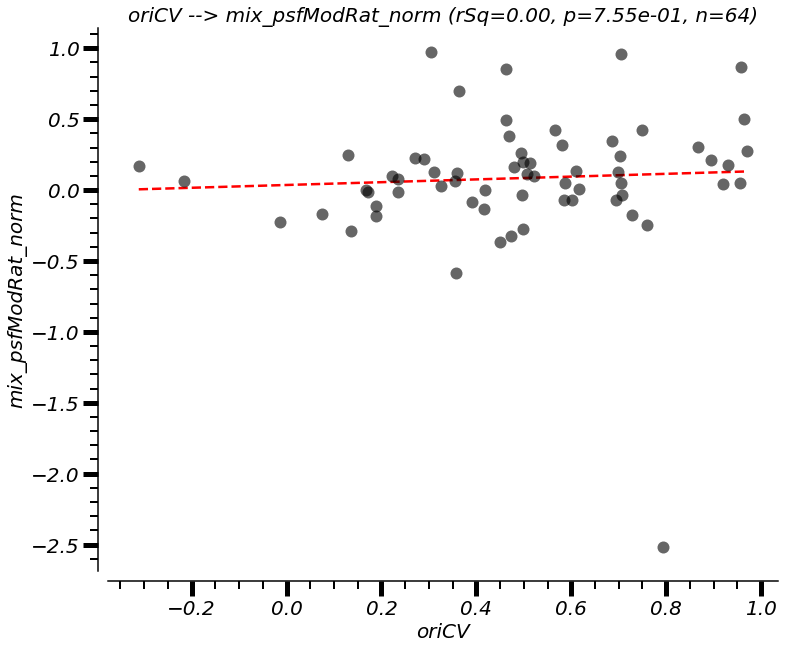

In [496]:
curr_key = (4, 6)

curr_mod = all_reg_1d[curr_key];
r_val, p_val, n_cells = curr_mod['rsquare'], curr_mod['pval'], curr_mod['n_cells']
ind_name, dep_name = curr_mod['ind_name'], curr_mod['dep_name'];
title = '%s --> %s (rSq=%.2f, p=%.2e, n=%d)' % (ind_name, dep_name, r_val, p_val, n_cells)

x_vals = all_ind[curr_key[1], :];
y_vals = all_dep[curr_key[0], :];

val_inds = np.logical_and(~np.isnan(x_vals), ~np.isnan(y_vals));

to_eval = np.linspace(np.min(x_vals[val_inds]), np.max(x_vals[val_inds]), 100)
mod_eval = curr_mod['model'].predict(sm.tools.add_constant(to_eval))

fCr = plt.figure(figsize=(12, 10))

if np.in1d(ind_name, all_ind_log_names):
    x_vals = np.power(2, x_vals);

    plt.xscale('log')
#     plt.xlim([np.round(np.nanmin(x_vals), decimals=1), np.round(np.nanmax(x_vals), decimals=0)])
    # plot the regression model
    plt.plot(np.power(2, to_eval), mod_eval, 'r--')
else:
    # plot the regression model
    plt.plot(to_eval, mod_eval, 'r--')

# plot the data
plt.plot(x_vals[val_inds], y_vals[val_inds], 'ko', alpha=0.6, markersize=12, clip_on=False);

plt.xlabel('%s' % ind_name);
plt.ylabel('%s' % dep_name);
plt.title(title);
sns.despine(offset=10);

# now save
save_loc_temp = save_loc + 'regr_examples/'
if not os.path.exists(save_loc_temp):
    os.makedirs(save_loc_temp)
pdfSv = pltSave.PdfPages(save_loc_temp + '%s_%s.pdf' % (ind_name, dep_name));
pdfSv.savefig(fCr) # only one figure here...
pdfSv.close()
# plt.close(fCr)

### Multiple regressors, one output
Having learned a bit from the one-to-one regression, let's try to put some of the more important/"useful" independent into one regression

In [419]:
ind_set = np.vstack((mix_sfPref, mix_bwHalf, supr_mod, f1f0, oriCV))

In [420]:
n_deps = all_dep.shape[0];
n_inds = ind_set.shape[0];

all_reg_nd = dict();

for i_dep in np.arange(n_deps): # consider the correlation with each of the independent variables
    all_reg_nd[i_dep] = dict();
    
    model = sm.OLS(endog=all_dep[i_dep, :], exog=sm.tools.add_constant(ind_set.transpose()), missing='drop', hasconst=True).fit()
    
    # Print out the statistics
    all_reg_nd[i_dep]['model'] = model;
    all_reg_nd[i_dep]['n_cells'] = int(model.nobs)
    all_reg_nd[i_dep]['rval'] = model.rsquared;
    all_reg_nd[i_dep]['dep_name'] = all_dep_names[i_dep]
    all_reg_nd[i_dep]['pval'] = model.pvalues; # there's only one pvalue, here
    

In [452]:
yr = pd.DataFrame(ind_set.transpose(), columns=('sfPref', 'bwHalf', 'supr_mod', 'f1f0', 'oriCV'));
yr.corr()

,sfPref,bwHalf,supr_mod,f1f0,oriCV
sfPref,1.000000,-0.135167,-0.039328,-0.457960,-0.083580
bwHalf,-0.135167,1.000000,0.033907,-0.032114,0.421788
supr_mod,-0.039328,0.033907,1.000000,-0.113531,0.101782
f1f0,-0.457960,-0.032114,-0.113531,1.000000,0.110804
oriCV,-0.083580,0.421788,0.101782,0.110804,1.000000


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  # Remove the CWD from sys.path while we load stuff.


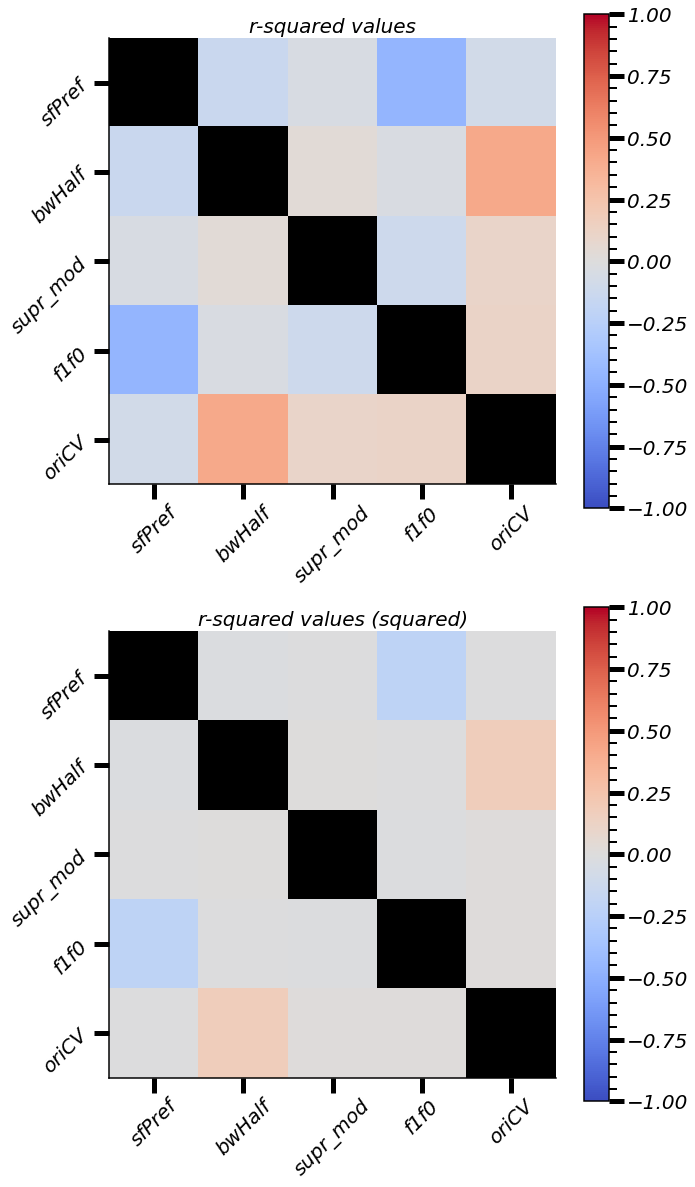

In [453]:
f, ax = plt.subplots(2, 1, figsize=(10, 2*10));

for i in range(2):
    plt.sca(ax[i])
    
    corrs = np.array(yr.corr());
    xdiag, ydiag = np.diag_indices_from(corrs)
    corrs[xdiag, ydiag] = np.nan;
    cmp = cm.coolwarm;
    cmp.set_bad('black')
    if i == 1:
        im = ax[i].imshow(np.sign(corrs)*np.square(corrs), cmap=cmp, vmin=-1, vmax=1);
    else:
        im = ax[i].imshow(corrs, cmap=cmp, vmin=-1, vmax=1);
    plt.xticks(np.arange(len(yr.columns)), yr.columns, rotation=45);
    plt.yticks(np.arange(len(yr.columns)), yr.columns, rotation=45);
    plt.tick_params(axis='both', which='minor', left=False, bottom=False)
    f.colorbar(im, ax=ax[i]);
    if i == 0:
        ax[i].set_title('r-squared values')
    else:
        ax[i].set_title('r-squared values (squared)')


In [451]:
# example regression output
depInd = 4
print('Explaining %s' % all_dep_names[depInd])
all_reg_nd[depInd]['model'].summary()

Explaining mix_psfModRat_norm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     6.512
Date:                Tue, 11 May 2021   Prob (F-statistic):           0.000107
Time:                        12:50:35   Log-Likelihood:                 2.9904
No. Observations:                  54   AIC:                             6.019
Df Residuals:                      48   BIC:                             17.95
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3036      0.137     -2.211      0.032      -0.580      -0.028
x1             0.2037      0.044      4.580      0.000       0.114       0.293
x2             0.0221      0.044      0.505      0.616      -0.066       0.110
x3            -0.2373      0.110     -2.167      0.035      -0.458      -0.017
x4            -0.0032      0.030     -0.105      0.917      -0.064       0.057
x5             0.3189      0.126      2.525      0.015       0.065       0.573
==============================================================================
Omnibus:                       11.644   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               11.724
Skew:                           1.065   Prob(JB):                      0.00285
Kurtosis:                       3.822   Cond. No.                         15.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [440]:
dep_names = [all_reg_nd[x]['dep_name'] for x in np.arange(len(all_reg_nd))];
rval = [all_reg_nd[x]['rval'] for x in np.arange(len(all_reg_nd))];

In [418]:
print('***How well is each metric explained?***')
["%s: r %.2f" % (x,y) for x, y in zip(dep_names, rval)]

***How well is each metric explained?***


['mix_bwHalfDiffData: r 0.22',
 'mix_prefRatData: r 0.07',
 'mix_sf70RatData: r 0.15',
 'mix_psfModRat: r 0.30',
 'mix_psfModRat_norm: r 0.40']

# Clustering

Now that we understand which tuning measures are correalted with one another and - more importantly - which might be useful in explaining the response metrics we care about (e.g. shift in prefSf with contrast)

## Kmeans

In [215]:
# data_labels = ('f1f0', 'mix_c50_eff', 'mix_sfPref', 'mix_bw34')
# data_subset = np.vstack((f1f0, mix_c50_eff, mix_sfPref, mix_bw34))

data_labels = ('f1f0', 'supr_mod', 'mix_c50_eff', 'mix_sf70', 'mix_bw34')
data_subset = np.vstack((f1f0, supr_mod, mix_c50_eff, mix_sf70, mix_bw34))

to_remove = np.unique(np.where(np.isnan(data_subset))[-1])

to_keep = np.setxor1d(np.arange(data_subset.shape[-1]), to_remove);

data_subset = data_subset[:, to_keep].transpose();

print('We started with %d cells; after removing NaN, now %d' % (f1f0.shape[0], data_subset.shape[0]));

We started with 92 cells; after removing NaN, now 58


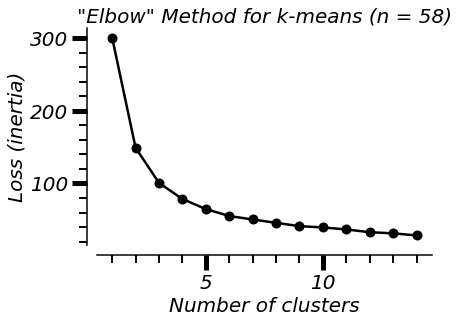

In [216]:
kmn_err = [];
kmn_ids = [];

k_nums = np.arange(1, 15)

for k_i in k_nums:
    kmeans = KMeans(n_clusters=k_i, init='k-means++', max_iter=300, n_init=10, random_state=None).fit(data_subset)
    kmn_err.append(kmeans.inertia_)
    kmn_ids.append(kmeans.labels_)
    
plt.plot(k_nums, kmn_err, 'k-o', markersize=10)
plt.title('"Elbow" Method for k-means (n = %d)' % data_subset.shape[0])
plt.xlabel('Number of clusters')
plt.ylabel('Loss (inertia)')
sns.despine(offset=10)

### Now, let z-score the data and re-do the k-means
Why? These clustering algorithms (and low-dimensional projecting) will be poor if the space is highly asymmetric. i.e., it should be as smooth and uniform as possible

In [217]:
z_scored = ss.zscore(data_subset, axis=0)

# print('We started with %d cells; after removing NaN, now %d' % (f1f0.shape[0], data_subset.shape[0]));

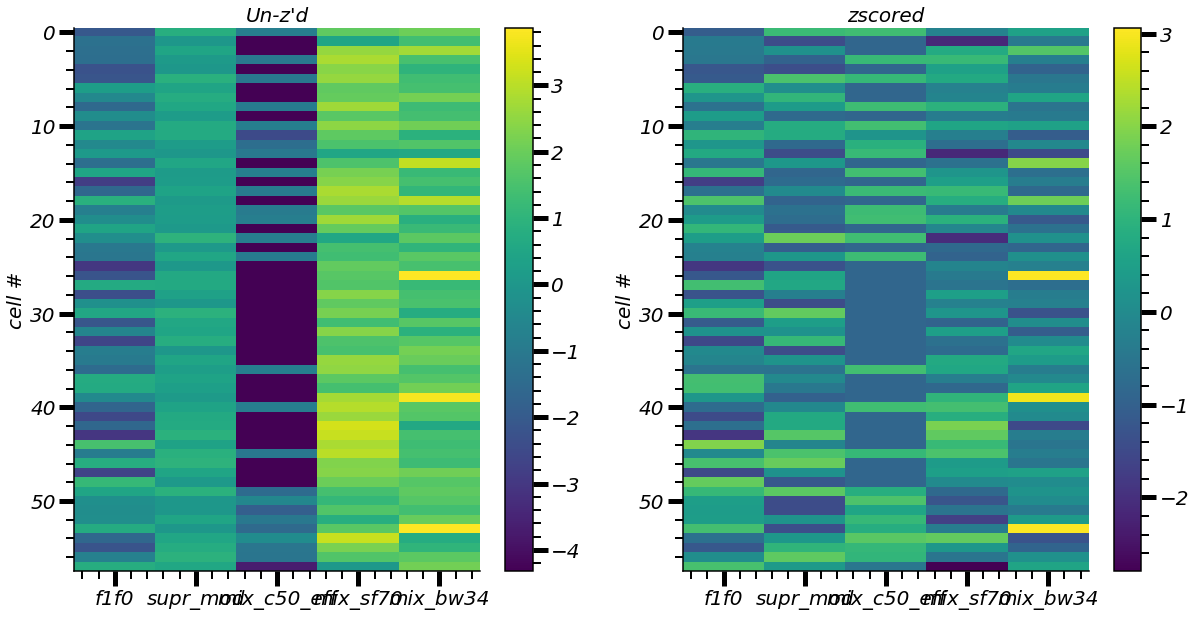

In [218]:
f, ax = plt.subplots(1, 2, figsize=(20, 10))

oh = ax[0].imshow(data_subset, aspect='auto');
ax[0].set_ylabel('cell #')
ax[0].set_title('Un-z\'d')
f.colorbar(oh, ax=ax[0])
plt.sca(ax[0])
plt.xticks(range(len(data_labels)), data_labels);

ah = ax[1].imshow(z_scored, aspect='auto');
ax[1].set_ylabel('cell #')
ax[1].set_title('zscored')
f.colorbar(ah, ax=ax[1])
plt.sca(ax[1])
plt.xticks(range(len(data_labels)), data_labels);

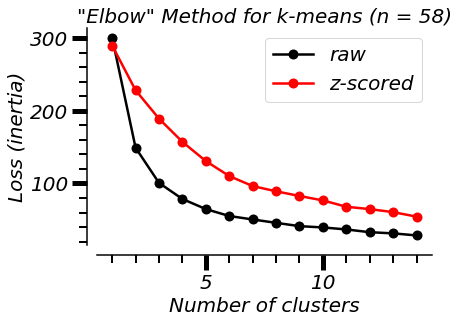

In [219]:
kmn_err_z = [];
kmn_ids_z = [];

k_nums = np.arange(1, 15)

for k_i in k_nums:
    kmeans = KMeans(n_clusters=k_i, init='k-means++', max_iter=300, n_init=10, random_state=None).fit(z_scored)
    kmn_err_z.append(kmeans.inertia_)
    kmn_ids_z.append(kmeans.labels_)
    
plt.plot(k_nums, kmn_err, 'k-o', markersize=10, label='raw')
plt.plot(k_nums, kmn_err_z, 'r-o', markersize=10, label='z-scored')
plt.title('"Elbow" Method for k-means (n = %d)' % data_subset.shape[0])
plt.xlabel('Number of clusters')
plt.ylabel('Loss (inertia)')
plt.legend()
sns.despine(offset=10)

### How stable is the k-means clustering?

In [220]:
nIts = 10
# nIts = 1000;
n_clust = 5;
nCells = z_scored.shape[0];
ids = np.nan * np.zeros((nCells, nIts))
ids_relabel = np.copy(ids);

for i in np.arange(nIts):
    kmeans_resamp = KMeans(n_clusters=n_clust, init='k-means++', max_iter=500, n_init=10, random_state=None).fit(z_scored)
    
    ids[:, i] = kmeans_resamp.labels_

    # we'll remap the IDs, such that whatever cluster cell 0 is assigned to is cluster 0;
    # - then, the first cell that isn't the same cluster as cell 0 is cluster 1;
    # - and so on...
    prev_n = [];
    for clus_i in np.arange(n_clust):
        if np.array_equal(prev_n, []):
            curr_id = ids[0, i];
        else: # go to the first index that hasn't been covered before; get that index
            curr_id = ids[np.setdiff1d(np.arange(nCells), prev_n)[0], i];
        # then, find what other cells have the label, and remap it clus_i
        remap_inds = np.where(kmeans_resamp.labels_ == curr_id)[0];
        prev_n = np.hstack((prev_n, remap_inds))
        ids_relabel[remap_inds, i] = clus_i

# Now, compute the stability:
# - first, we get the labels, and take a histogram (n_clust possible bins)
# - then, divide
stability = np.nan*np.zeros((nCells, ))
for cell_i in np.arange(nCells):
    curr_labels = ids_relabel[cell_i, :]
    curr_bins = np.histogram(curr_labels, np.arange(n_clust+0.1))[0]
    stability[cell_i, ] = np.divide(1, np.sum(np.square(np.divide(curr_bins[:], np.sum(curr_bins)))))

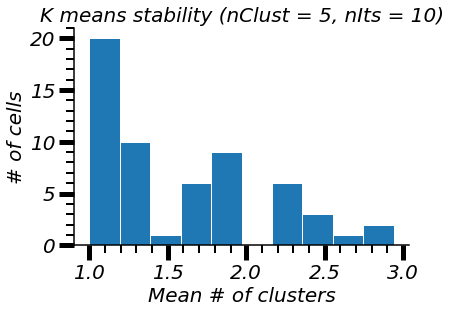

In [221]:
plt.hist(stability);
plt.title('K means stability (nClust = %d, nIts = %d)' % (n_clust, nIts));
plt.xlabel('Mean # of clusters');
plt.ylabel('# of cells');

## Agglomerative

In [222]:
### First, agglomerative clustering (meaning we build up clusters from the bottom up) 
# without specifying the number of clusters to see how the data shape up hierarchically

# default linkage is Ward, which requires euclidian distance (affinity) metric
agg = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(z_scored) 

In [223]:
# from: https://scikit-learn.org/stable/auto_examples/cluster/plot_digits_linkage.html
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    n_labs = len(np.unique(labels))
    
    plt.figure(figsize=(6, 4))
    for i in range(X_red.shape[0]):
        plt.text(X_red[i, 0], X_red[i, 1], str(labels[i]),
                 color=plt.cm.nipy_spectral(labels[i] / n_labs),
                 fontdict={'weight': 'bold', 'size': 9})

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

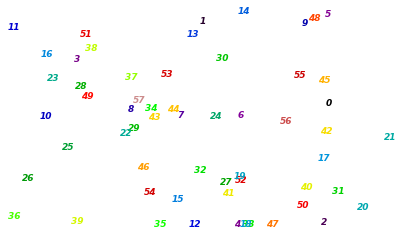

In [224]:
plot_clustering(z_scored, agg.labels_)

In [225]:
# copied from: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

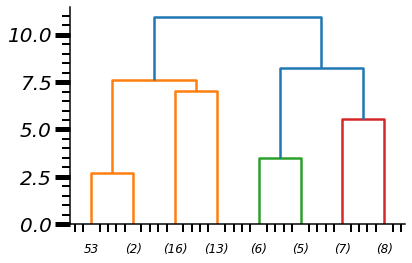

In [226]:
plot_dendrogram(agg, truncate_mode='level', p=2)

In [227]:
### Now, we specify the number of clusters

# default linkage is Ward, which requires euclidian distance (affinity) metric
n_clust = 5;
agg = AgglomerativeClustering(n_clusters=n_clust).fit(z_scored) 

### How stable is the agglomerative clustering?

In [228]:
nIts = 100;
n_clust = 5;
nCells = z_scored.shape[0];
ids = np.nan * np.zeros((nCells, nIts))
ids_relabel = np.copy(ids);

for i in np.arange(nIts):
    agg_resamp = AgglomerativeClustering(n_clusters=n_clust).fit(z_scored);
    
    ids[:, i] = agg_resamp.labels_

    # we'll remap the IDs, such that whatever cluster cell 0 is assigned to is cluster 0;
    # - then, the first cell that isn't the same cluster as cell 0 is cluster 1;
    # - and so on...
    prev_n = [];
    for clus_i in np.arange(n_clust):
        if np.array_equal(prev_n, []):
            curr_id = ids[0, i];
        else: # go to the first index that hasn't been covered before; get that index
            curr_id = ids[np.setdiff1d(np.arange(nCells), prev_n)[0], i];
        # then, find what other cells have the label, and remap it clus_i
        remap_inds = np.where(agg_resamp.labels_ == curr_id)[0];
        prev_n = np.hstack((prev_n, remap_inds))
        ids_relabel[remap_inds, i] = clus_i

    
# Now, compute the stability:
# - first, we get the labels, and take a histogram (n_clust possible bins)
# - then, divide
stability = np.nan*np.zeros((nCells, ))
for cell_i in np.arange(nCells):
    curr_labels = ids_relabel[cell_i, :]
    curr_bins = np.histogram(curr_labels, np.arange(n_clust+0.1))[0]
    stability[cell_i, ] = np.divide(1, np.sum(np.square(np.divide(curr_bins[:], np.sum(curr_bins)))))

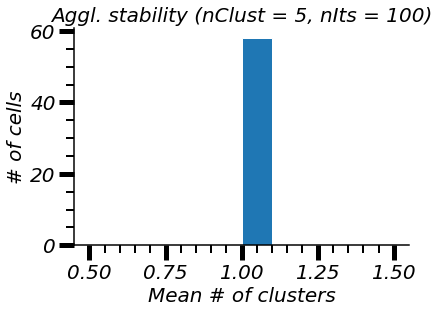

In [229]:
plt.hist(stability);
plt.title('Aggl. stability (nClust = %d, nIts = %d)' % (n_clust, nIts));
plt.xlabel('Mean # of clusters');
plt.ylabel('# of cells');

Very stable, it seems - each cell only is placed in one cluster across all runs of the clustering algorithm

## Comparing k-means and agglomerative

For equal number of clusters, how overlapped are the cluster IDs?

In [230]:
n_clust = 5;
nIts = 100;
nCells = z_scored.shape[0];

ids_relabel_k = np.nan * np.zeros((nCells, nIts))
ids_relabel_a = np.copy(ids_relabel_k)

pct_corr = np.nan * np.zeros((nIts, ))

for i in np.arange(nIts):

    kmeans = KMeans(n_clusters=n_clust, init='k-means++', max_iter=300, n_init=10, random_state=None).fit(z_scored)
    agg = AgglomerativeClustering(n_clusters=n_clust).fit(z_scored) 

    ids_k = kmeans.labels_
    ids_a = agg.labels_

    ### relabel so that we can compare
    prev_n_k = []; prev_n_a = [];
    for clus_i in np.arange(n_clust):
        if np.array_equal(prev_n_k, []):
            curr_id_k = ids_k[0];
        else: # go to the first index that hasn't been covered before; get that index
            curr_id_k = ids_k[np.setdiff1d(np.arange(nCells), prev_n_k)[0]];

        if np.array_equal(prev_n_a, []):
            curr_id_a = ids_a[0];
        else: # go to the first index that hasn't been covered before; get that index
            curr_id_a = ids_a[np.setdiff1d(np.arange(nCells), prev_n_a)[0]];

        # then, find what other cells have the label, and remap it clus_i
        remap_inds_k = np.where(kmeans.labels_ == curr_id_k)[0];
        remap_inds_a = np.where(agg.labels_ == curr_id_a)[0];

        prev_n_k = np.hstack((prev_n_k, remap_inds_k))
        prev_n_a = np.hstack((prev_n_a, remap_inds_a))

        ids_relabel_k[remap_inds_k, i] = clus_i
        ids_relabel_a[remap_inds_a, i] = clus_i

        pct_corr[i] = 100*np.divide(np.sum(np.equal(ids_relabel_a[:, i], ids_relabel_k[:, i])), nCells)

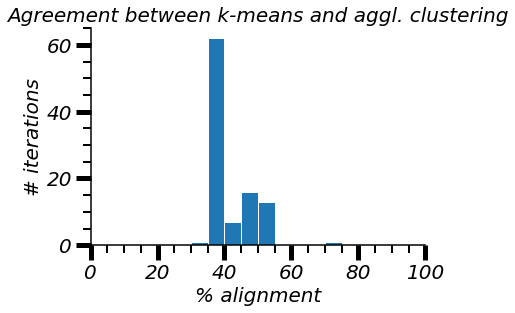

In [231]:
plt.hist(pct_corr, bins=np.linspace(0, 100, 21));
plt.title('Agreement between k-means and aggl. clustering')
plt.ylabel('# iterations')
plt.xlabel('% alignment')
plt.xlim([0, 100]);

## tSNE for plotting

In [232]:
tsne = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=6000)
tsne_results = tsne.fit_transform(z_scored)

[t-SNE] Computing 57 nearest neighbors...
[t-SNE] Indexed 58 samples in 0.001s...
[t-SNE] Computed neighbors for 58 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 58 / 58
[t-SNE] Mean sigma: 1.477289
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.768536
[t-SNE] KL divergence after 1150 iterations: 0.326360


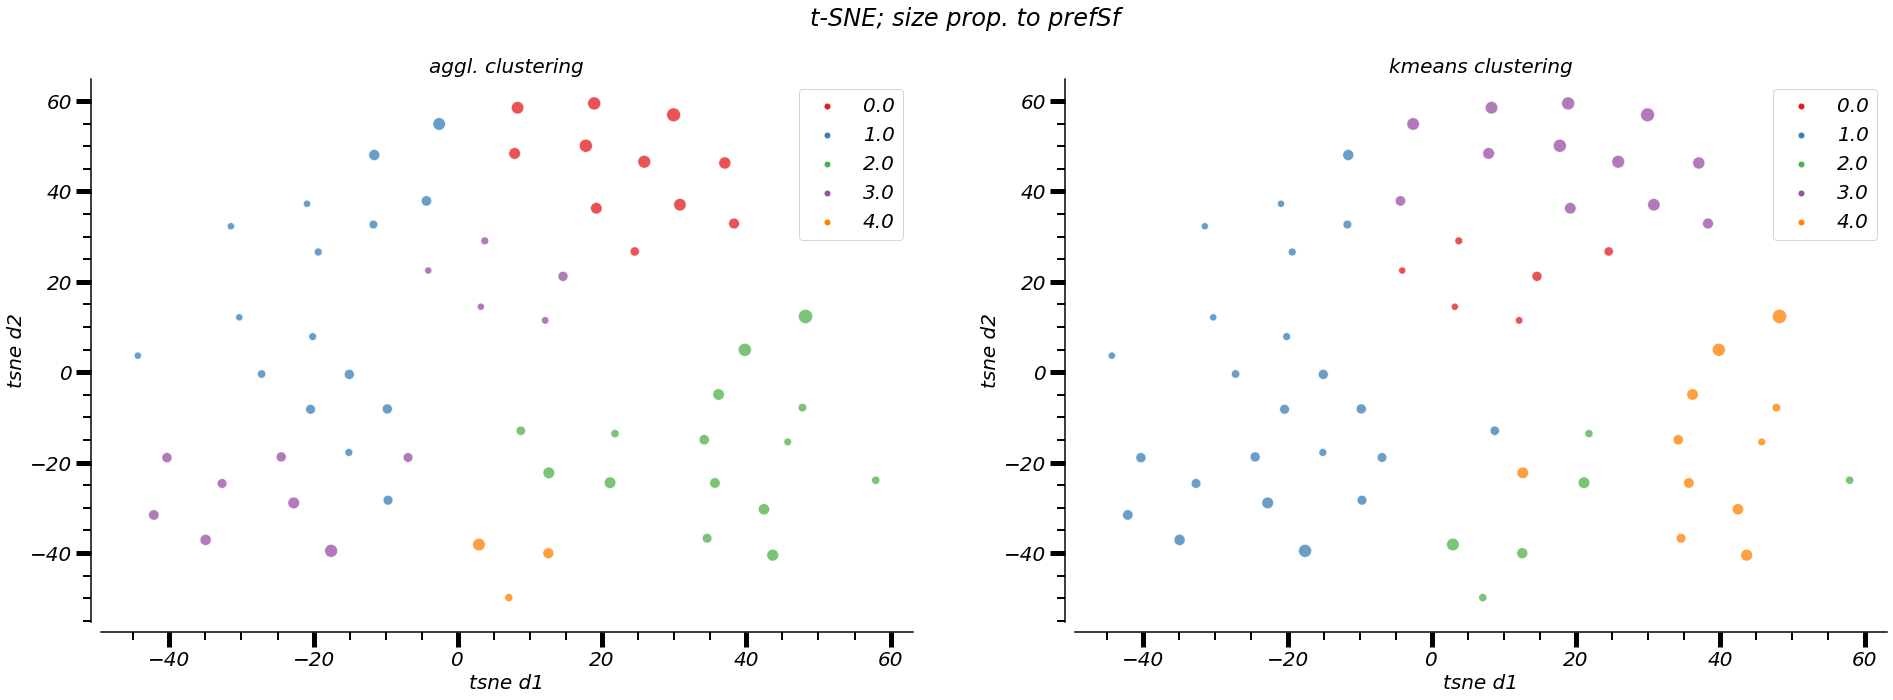

In [233]:
d1 = tsne_results[:,0]
d2 = tsne_results[:,1]

labels = (ids_relabel_a[:, 0], ids_relabel_k[:, 0])
names = ('aggl.', 'kmeans');

f, ax = plt.subplots(1, 2, figsize=(2*16,10))

f.suptitle('t-SNE; size prop. to prefSf');

for i in np.arange(2):

    clr = labels[i];
    n_clust = len(np.unique(clr))
    # clr = kmn_ids[4];

    # szs = np.maximum(50, 100 + np.multiply(50, ss.zscore(mix_c50_eff[to_keep])));
    # plt.title('t-SNE; size prop. to effective c50')

    szs = np.maximum(50, 100 + np.multiply(50, ss.zscore(mix_sfPref[to_keep])));
    ax[i].set_title('%s clustering' % names[i])


    sns.scatterplot(
        x=d1, y=d2,
        hue=clr,
        palette=sns.color_palette("Set1", n_clust),
        alpha=0.75,
        s=szs,
        ax=ax[i]
    )

    my_cmap = ListedColormap(sns.color_palette("Set1", n_clust).as_hex())

    ax[i].legend()
    # plt.legend(labels=['clust %d' %x for x in np.arange(n_clust)])
    ax[i].set_xlabel('tsne d1');
    ax[i].set_ylabel('tsne d2');
    sns.despine(offset=10, ax=ax[i])
    
# now save
if not os.path.exists(save_loc):
    os.makedirs(save_loc)
pdfSv = pltSave.PdfPages(save_loc + 'tsne_viz_clus#%02d.pdf' % n_clust);
pdfSv.savefig(f) # only one figure here...
pdfSv.close()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

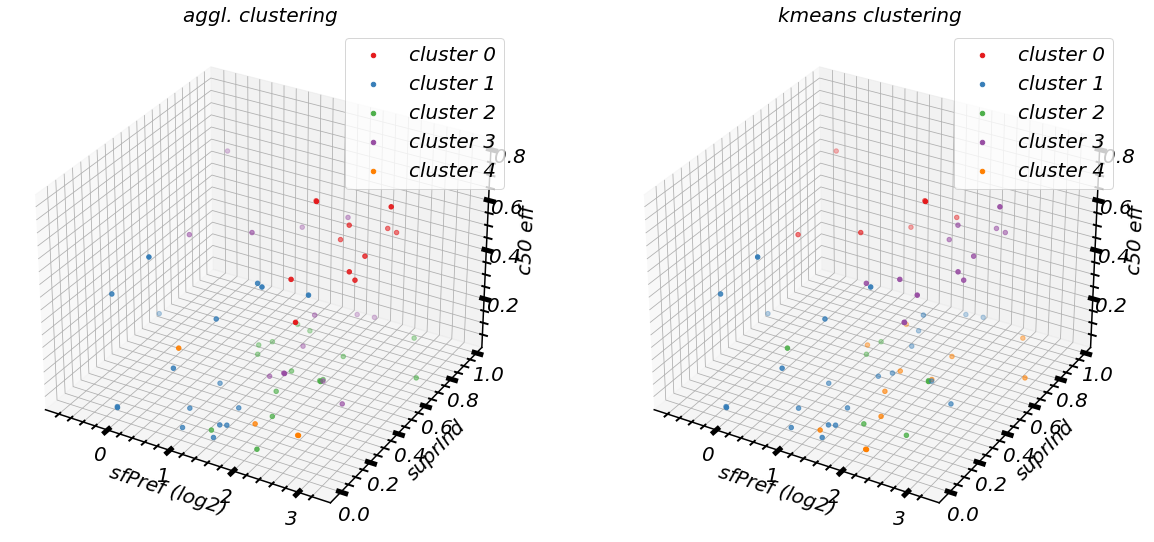

In [234]:
### Maybe a 3d plot, too?
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# from: https://matplotlib.org/3.1.1/gallery/mplot3d/scatter3d.html
f = plt.figure(figsize=(20,10))

### first, aggl.
ax = f.add_subplot(1,2,1, projection='3d')

palette=sns.color_palette("Set1", n_clust)

outs = ax.scatter(mix_sfPref[to_keep], supr_mod[to_keep], np.power(2, mix_c50_eff[to_keep]), c=labels[0], cmap=my_cmap);
clust_inds = np.array([np.where(labels[0]==i)[0][0] for i in np.arange(n_clust)])
# now, replot (get the correct colors) just one point from each cluster so that we have a correct label
outs_clrs = outs._facecolors; # to ensure the right colors in the below
cs = [ax.scatter(mix_sfPref[to_keep[ind]], supr_mod[to_keep[ind]], np.power(2, mix_c50_eff[to_keep[ind]]), c=outs_clrs[ind]) for ind in clust_inds]
ax.legend(cs, ['cluster %d' % x for x in np.arange(n_clust)])
ax.set_xlabel('sfPref (log2)');
ax.set_ylabel('suprInd');
ax.set_zlabel('c50 eff');
ax.set_title('%s clustering' % names[0])

### then kmeans
ax = f.add_subplot(122, projection='3d')

palette=sns.color_palette("Set1", n_clust)

outs = ax.scatter(mix_sfPref[to_keep], supr_mod[to_keep], np.power(2, mix_c50_eff[to_keep]), c=labels[1], cmap=my_cmap);
clust_inds = np.array([np.where(labels[1]==i)[0][0] for i in np.arange(n_clust)])
# now, replot (get the correct colors) just one point from each cluster so that we have a correct label
outs_clrs = outs._facecolors; # to ensure the right colors in the below
cs = [ax.scatter(mix_sfPref[to_keep[ind]], supr_mod[to_keep[ind]], np.power(2, mix_c50_eff[to_keep[ind]]), c=outs_clrs[ind]) for ind in clust_inds]
ax.legend(cs, ['cluster %d' % x for x in np.arange(n_clust)])
ax.set_xlabel('sfPref (log2)');
ax.set_ylabel('suprInd');
ax.set_zlabel('c50 eff');
ax.set_title('%s clustering' % names[1])

sns.despine(offset=5)

Now, what are the real indices (in jointList) for these cells, and there directory/cellnum:

#### Do these cells have similar output tuning measures (i.e. sfModRat, suprInd, corrWithErr)?

In [235]:
lbls = agg.labels_;
# lbls = kmeans.labels_;

core_metrics = ','.join(data_labels); # labels..
print('metrics: %s' % core_metrics)

allVals = [];
allMed = [];
allMn = [];
allStd = [];
allInds = [];

for i in np.unique(lbls):
    which_inds = np.where(lbls == i)[0];
    joint_inds = to_keep[which_inds];
    base_dir = [jointList[i]['metadata']['fullPath'].split('/')[-3] for i in joint_inds]
    cell_num = [jointList[i]['metadata']['cellNum'] for i in joint_inds]

    allInds.append(joint_inds);
    
    # now, transform data_subset to unlog some values:
    data_subout = np.copy(data_subset)
    for ind, nm in enumerate(data_labels):
        if np.in1d(nm, all_ind_log_names):
             data_subout[:, ind] = np.power(2, data_subset[:, ind]);

    medVals = np.median(data_subout[which_inds, :], axis=0)
    mnVals = np.mean(data_subout[which_inds, :], axis=0)
    stdVals = np.std(data_subout[which_inds, :], axis=0)
    
    if np.array_equal(allMed, []):
        allMed = medVals;
        allMn = mnVals;
        allStd = stdVals;
    else:
        allMed = np.vstack((allMed, medVals))
        allMn = np.vstack((allMn, mnVals))
        allStd = np.vstack((allStd, stdVals))

    print('\ncluster %d (N=%d):\n\t\t(median %s)' % (i, len(which_inds), ', '.join(['%.2f' % x for x in medVals])))
    
    if np.array_equal(allVals, []):
        allVals = [data_subout[which_inds, :]];
    else:
        allVals.append(data_subout[which_inds, :]);
    
    [print('\t %s/%d:\t%s' % (x,y,', '.join(['%.2f' % x for x in data_subout[which_inds[i],:]]))) for i, (x, y) in enumerate(zip(base_dir, cell_num))]

metrics: f1f0,supr_mod,mix_c50_eff,mix_sf70,mix_bw34

cluster 0 (N=13):
		(median 1.33, 0.66, 0.05, 3.50, 1.44)
	 V1_orig/7:	1.19, 0.47, 0.05, 3.63, 1.44
	 V1_orig/12:	1.33, 0.68, 0.18, 3.56, 0.92
	 V1_orig/30:	0.83, 0.97, 0.56, 1.49, 1.80
	 V1_orig/32:	0.47, 0.53, 0.54, 2.56, 1.78
	 V1_orig/35:	1.62, 0.66, 0.05, 3.10, 1.20
	 V1_orig/39:	1.50, 0.94, 0.05, 4.60, 0.75
	 V1_orig/41:	0.66, 0.49, 0.05, 5.24, 0.91
	 V1_orig/46:	1.66, 0.43, 0.05, 3.50, 1.66
	 V1_orig/56:	2.80, 0.40, 0.05, 7.10, 1.31
	 V1_orig/58:	1.73, 0.96, 0.05, 4.97, 1.31
	 V1/3:	1.42, 0.92, 0.36, 2.76, 1.84
	 V1/8:	0.83, 0.50, 0.48, 1.77, 1.97
	 V1/22:	0.61, 0.93, 0.45, 3.14, 1.80

cluster 1 (N=15):
		(median 0.21, 0.53, 0.05, 5.23, 1.70)
	 V1_orig/3:	0.40, 0.49, 0.05, 6.00, 2.74
	 V1_orig/5:	0.21, 0.01, 0.05, 5.36, 1.01
	 V1_orig/8:	0.70, 0.76, 0.05, 3.78, 2.15
	 V1_orig/17:	0.39, 0.53, 0.05, 3.02, 3.12
	 V1_orig/20:	0.14, 0.21, 0.05, 5.23, 1.45
	 V1_orig/33:	0.12, 0.04, 0.05, 3.74, 1.50
	 V1_orig/34:	0.22, 0.63, 0.05, 3

/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


First, what about the tuning measures that we clustered on?

0 vs. 1: pvalue 0.000 (ttest)
0 vs. 2: pvalue 0.000 (ttest)
0 vs. 3: pvalue 0.761 (ttest)
0 vs. 4: pvalue 0.230 (ttest)
1 vs. 2: pvalue 0.217 (ttest)
1 vs. 3: pvalue 0.000 (ttest)
1 vs. 4: pvalue 0.000 (ttest)
2 vs. 3: pvalue 0.000 (ttest)
2 vs. 4: pvalue 0.000 (ttest)
3 vs. 4: pvalue 0.260 (ttest)
0 vs. 1: pvalue 0.073 (ttest)
0 vs. 2: pvalue 0.283 (ttest)
0 vs. 3: pvalue 0.001 (ttest)
0 vs. 4: pvalue 0.000 (ttest)
1 vs. 2: pvalue 0.506 (ttest)
1 vs. 3: pvalue 0.018 (ttest)
1 vs. 4: pvalue 0.000 (ttest)
2 vs. 3: pvalue 0.007 (ttest)
2 vs. 4: pvalue 0.000 (ttest)
3 vs. 4: pvalue 0.711 (ttest)
0 vs. 1: pvalue 0.004 (ttest)
0 vs. 2: pvalue 0.000 (ttest)
0 vs. 3: pvalue 0.602 (ttest)
0 vs. 4: pvalue 0.776 (ttest)
1 vs. 2: pvalue 0.000 (ttest)
1 vs. 3: pvalue 0.020 (ttest)
1 vs. 4: pvalue 0.004 (ttest)
2 vs. 3: pvalue 0.000 (ttest)
2 vs. 4: pvalue 0.001 (ttest)
3 vs. 4: pvalue 0.525 (ttest)
0 vs. 1: pvalue 0.041 (ttest)
0 vs. 2: pvalue 0.000 (ttest)
0 vs. 3: pvalue 0.091 (ttest)
0 vs. 4: p

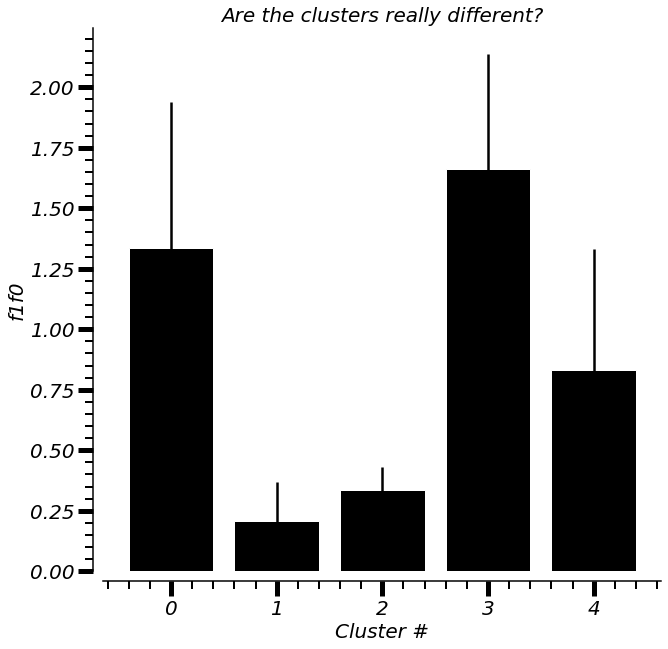

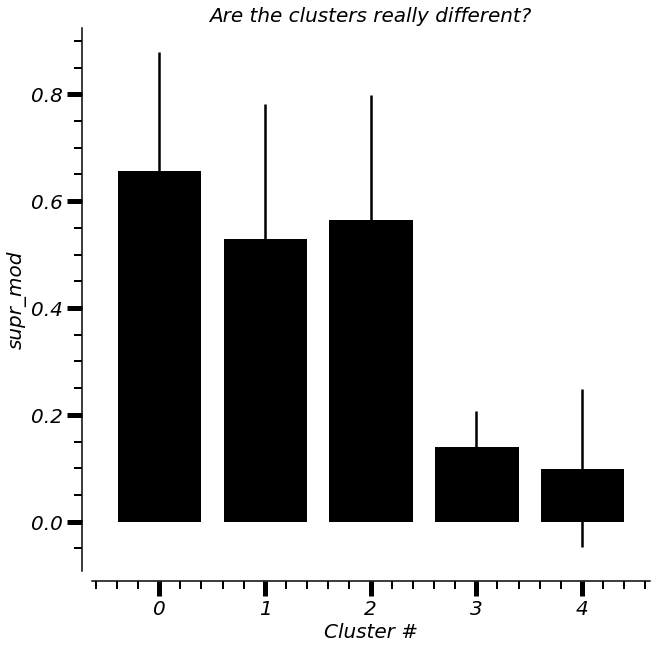

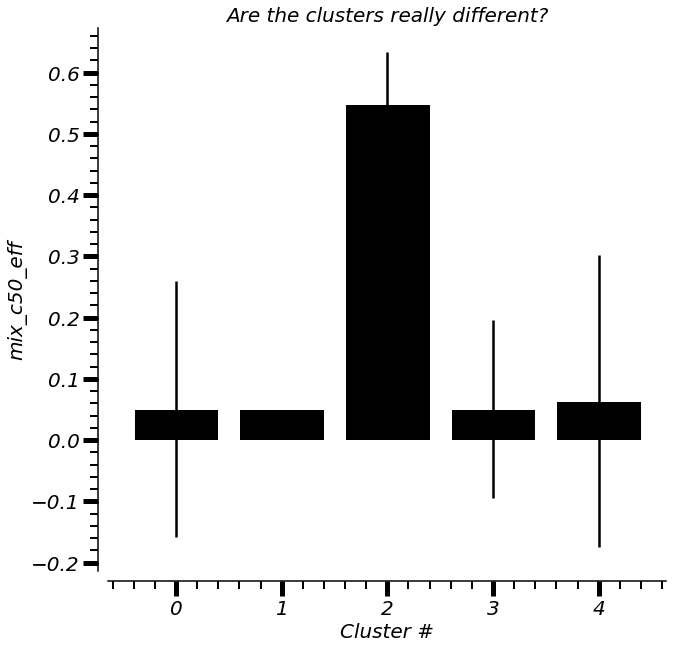

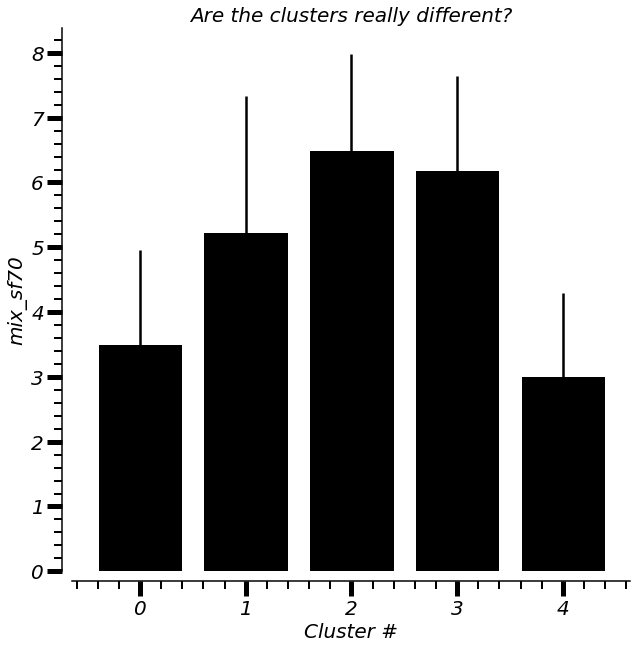

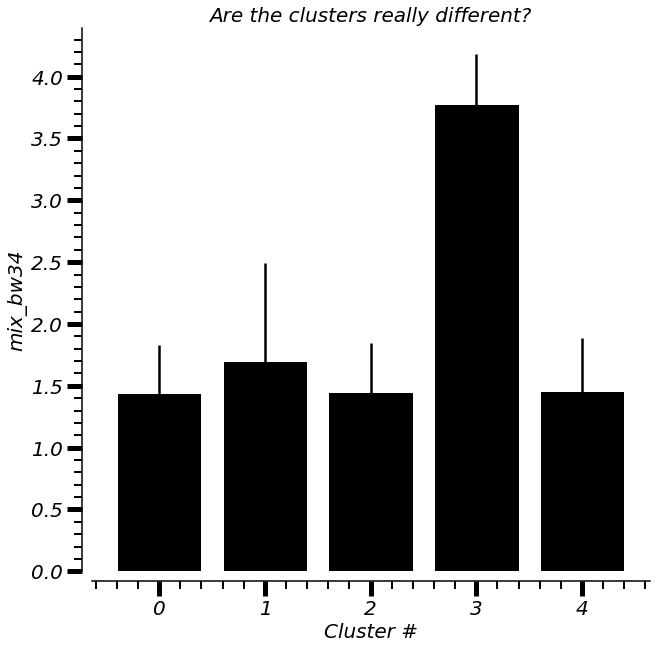

In [236]:
for metr in np.arange(5):

    # metr = 4;

    f = plt.figure(figsize=(10, 10))

    plt.xlabel('Cluster #');
    plt.ylabel(data_labels[metr]);
    plt.title('Are the clusters really different?')

    [plt.bar(ii, x[metr], yerr=allStd[ii][metr], color='k') for ii, x in enumerate(allMed)];
    sns.despine(offset=10)

    for comb in itertools.combinations(range(n_clust), 2):
        p_val = ss.ttest_ind(allVals[comb[0]][:, metr], allVals[comb[1]][:, metr]).pvalue
        print('%d vs. %d: pvalue %.3f (ttest)' % (comb[0], comb[1], p_val))

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + 'clus#%02d_ind_%s.pdf' % (n_clust, data_labels[metr]));
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()

Now, the output metrics we are interested in...

In [237]:
all_dep_names

['mix_bwHalfDiffData',
 'mix_bw34DiffData',
 'mix_prefRatData',
 'mix_sf70RatData',
 'mix_dog_bwHalfDiffData',
 'mix_dog_bw34DiffData',
 'mix_dog_prefRatData',
 'mix_dog_sf70RatData',
 'mix_psfModRat',
 'mix_psfModRat_norm']

metric: mix_bwHalfDiffData
	0 (n=10) vs. 1 (n=14): pvalue 0.124 (ttest)
	0 (n=10) vs. 2 (n=8): pvalue 0.104 (ttest)
	0 (n=10) vs. 3 (n=1): pvalue nan (ttest)
	0 (n=10) vs. 4 (n=13): pvalue 0.080 (ttest)
	1 (n=14) vs. 2 (n=8): pvalue 0.295 (ttest)
	1 (n=14) vs. 3 (n=1): pvalue nan (ttest)
	1 (n=14) vs. 4 (n=13): pvalue 0.377 (ttest)
	2 (n=8) vs. 3 (n=1): pvalue nan (ttest)
	2 (n=8) vs. 4 (n=13): pvalue 0.810 (ttest)
	3 (n=1) vs. 4 (n=13): pvalue nan (ttest)


/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/users/plevy/miniconda3/envs/pytorch-lcv/lib/python3.6/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


metric: mix_bw34DiffData
	0 (n=12) vs. 1 (n=15): pvalue 0.033 (ttest)
	0 (n=12) vs. 2 (n=8): pvalue 0.069 (ttest)
	0 (n=12) vs. 3 (n=1): pvalue nan (ttest)
	0 (n=12) vs. 4 (n=13): pvalue 0.036 (ttest)
	1 (n=15) vs. 2 (n=8): pvalue 0.543 (ttest)
	1 (n=15) vs. 3 (n=1): pvalue nan (ttest)
	1 (n=15) vs. 4 (n=13): pvalue 0.695 (ttest)
	2 (n=8) vs. 3 (n=1): pvalue nan (ttest)
	2 (n=8) vs. 4 (n=13): pvalue 0.810 (ttest)
	3 (n=1) vs. 4 (n=13): pvalue nan (ttest)
metric: mix_prefRatData
	0 (n=12) vs. 1 (n=15): pvalue 0.253 (ttest)
	0 (n=12) vs. 2 (n=10): pvalue 0.620 (ttest)
	0 (n=12) vs. 3 (n=1): pvalue nan (ttest)
	0 (n=12) vs. 4 (n=16): pvalue 0.975 (ttest)
	1 (n=15) vs. 2 (n=10): pvalue 0.392 (ttest)
	1 (n=15) vs. 3 (n=1): pvalue nan (ttest)
	1 (n=15) vs. 4 (n=16): pvalue 0.361 (ttest)
	2 (n=10) vs. 3 (n=1): pvalue nan (ttest)
	2 (n=10) vs. 4 (n=16): pvalue 0.701 (ttest)
	3 (n=1) vs. 4 (n=16): pvalue nan (ttest)
metric: mix_sf70RatData
	0 (n=12) vs. 1 (n=15): pvalue 0.245 (ttest)
	0 (n=12) 

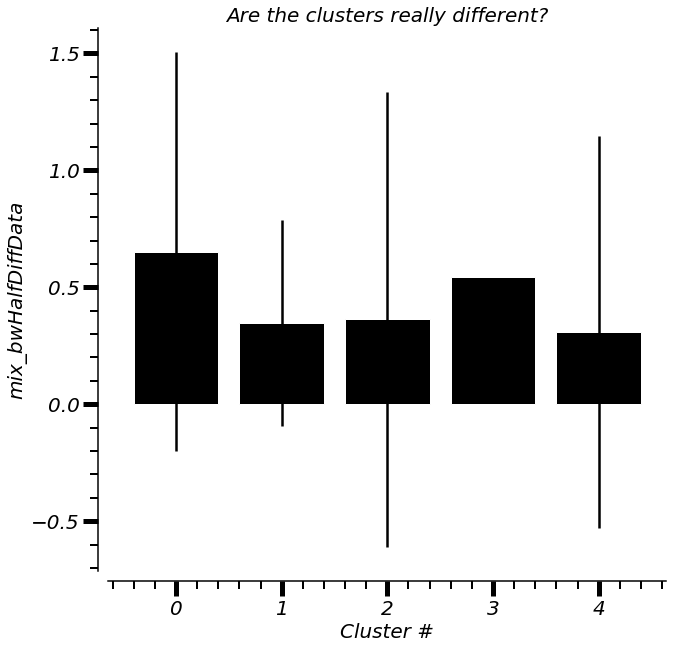

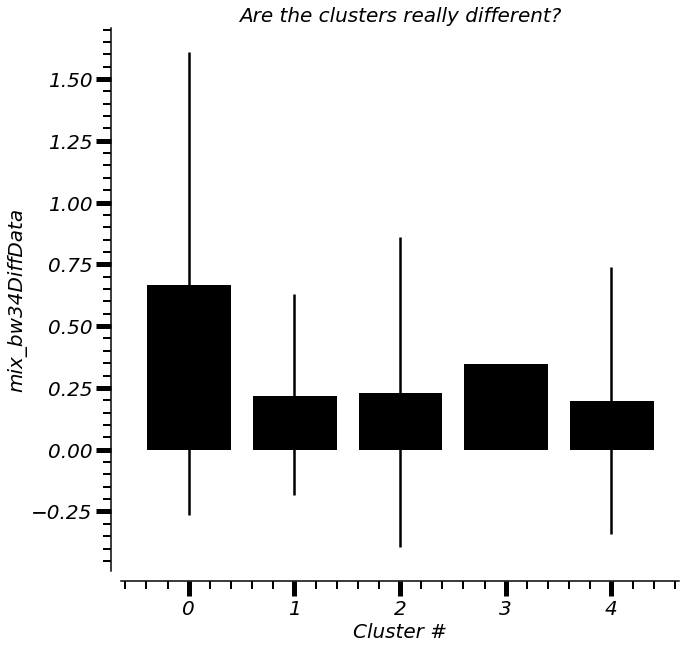

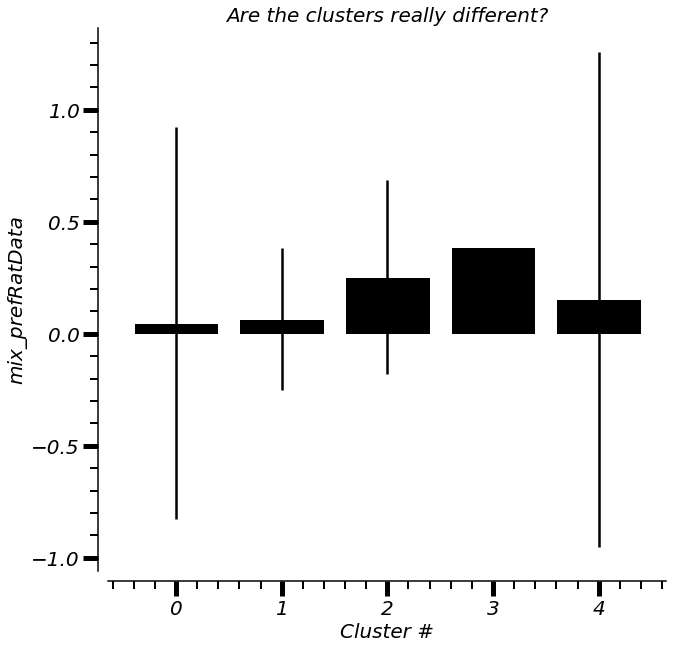

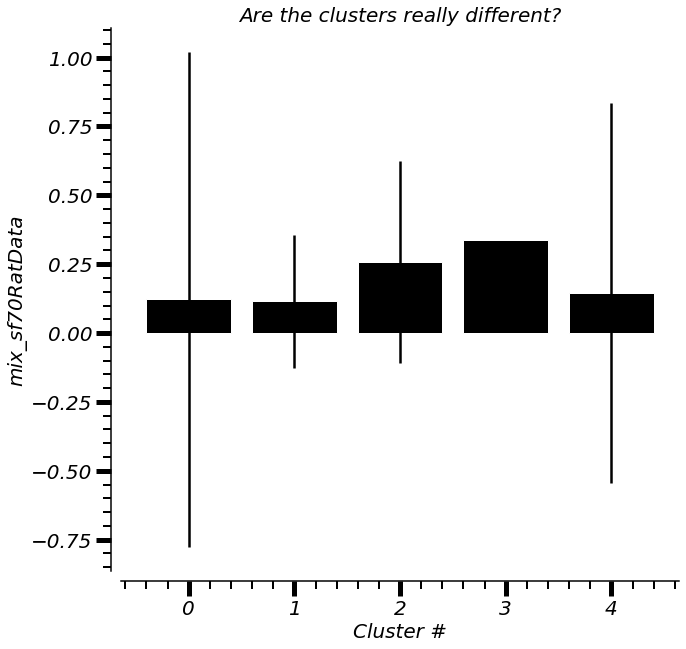

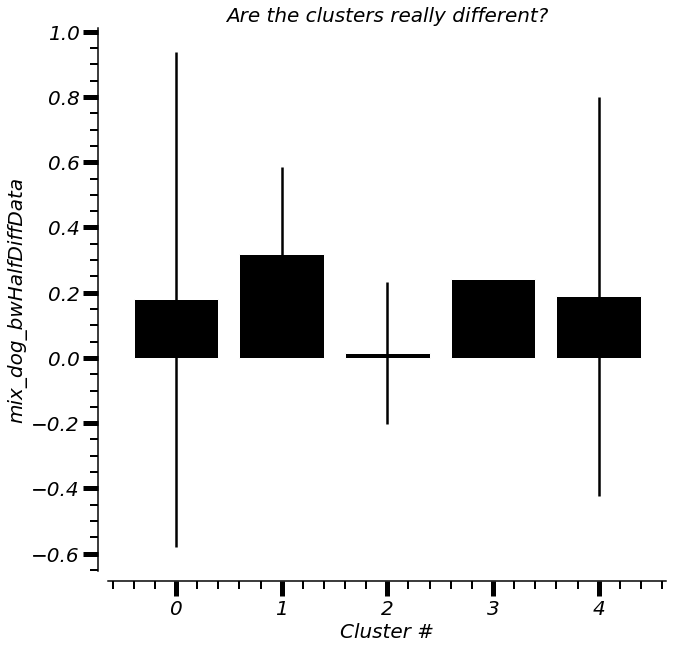

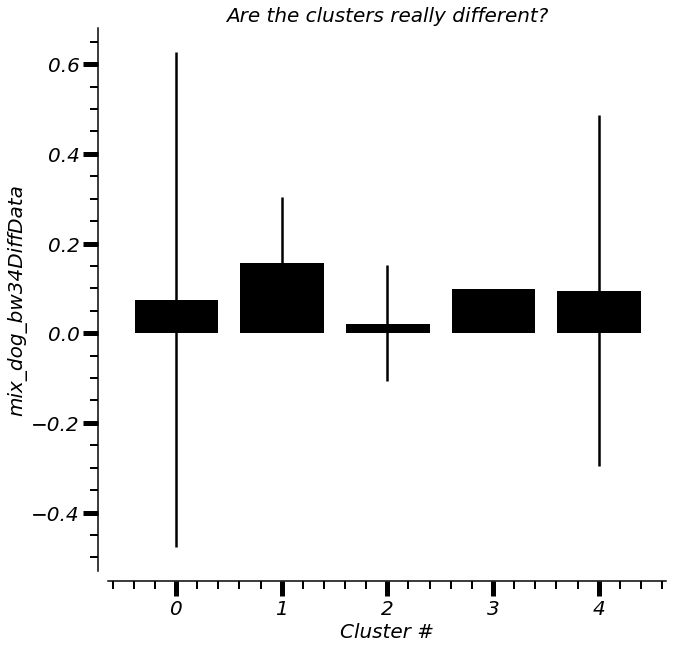

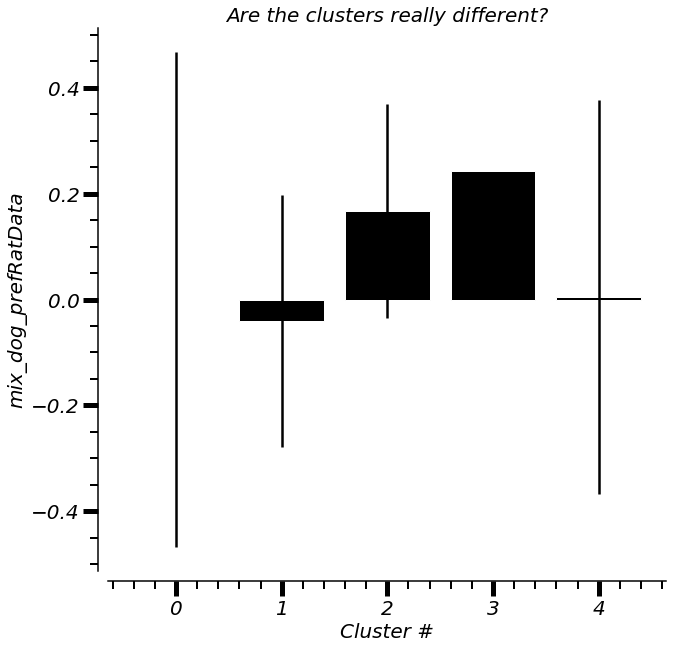

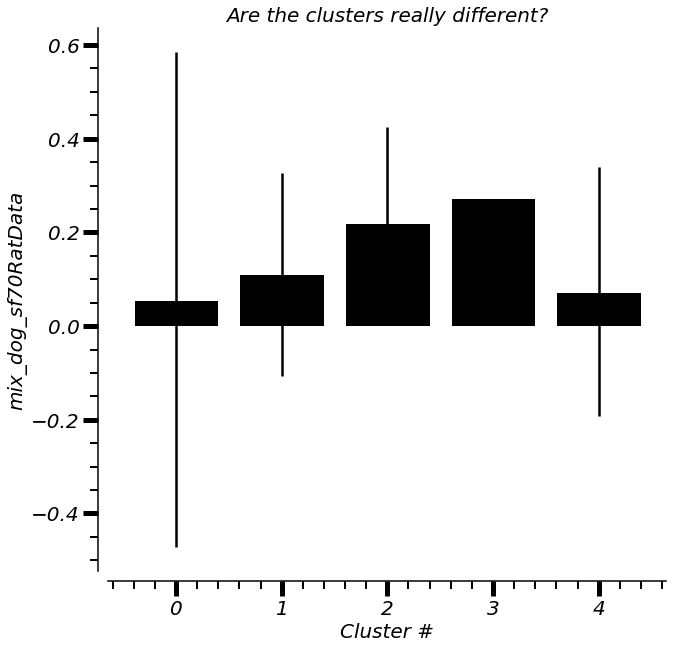

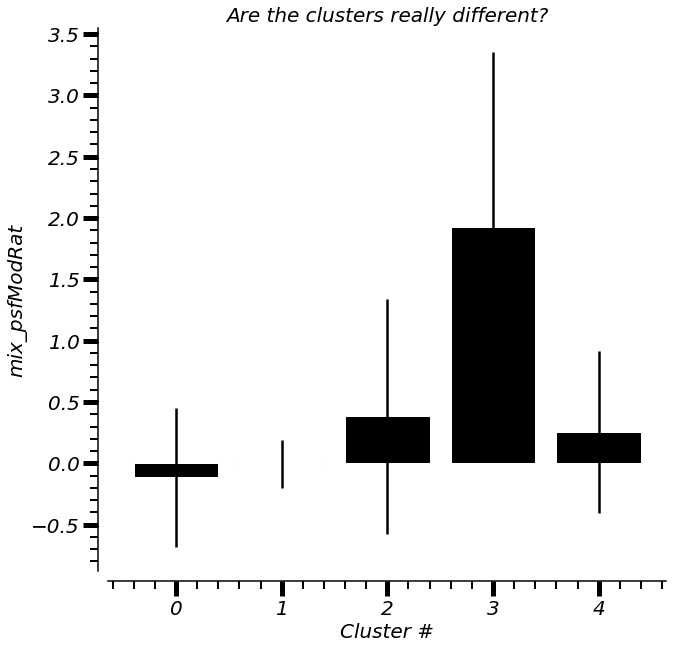

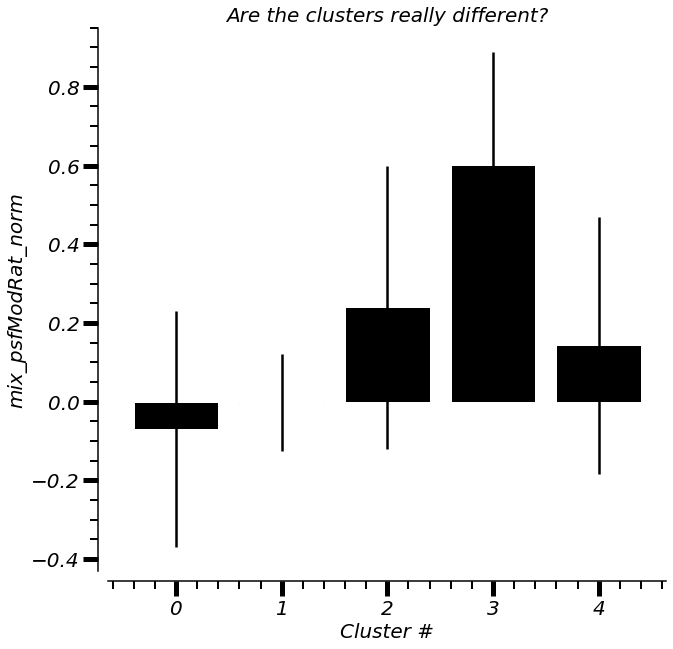

In [238]:
nMetr = len(all_dep_names);

for metr in np.arange(nMetr):

# metr = 7;
    vals = [all_dep[metr, curr_inds] for curr_inds in allInds]
    vals_trim = [val[~np.isnan(val)] for val in vals] # remove the NaN

    f = plt.figure(figsize=(10, 10))

    plt.xlabel('Cluster #');
    plt.ylabel(all_dep_names[metr]);
    plt.title('Are the clusters really different?')

    [plt.bar(ii, np.median(x), yerr=np.std(x), color='k') for ii, x in enumerate(vals_trim)];
    sns.despine(offset=10)

    print('metric: %s' % all_dep_names[metr])
    for comb in itertools.combinations(range(n_clust), 2):
        v1, v2 = vals_trim[comb[0]], vals_trim[comb[1]];
        p_val = ss.ttest_ind(v1, v2).pvalue
        print('\t%d (n=%d) vs. %d (n=%d): pvalue %.3f (ttest)' % (comb[0], len(v1), comb[1], len(v2), p_val))

    # now save
    if not os.path.exists(save_loc):
        os.makedirs(save_loc)
    pdfSv = pltSave.PdfPages(save_loc + 'clus#%02d_dep_%s.pdf' % (n_clust, all_dep_names[metr]));
    pdfSv.savefig(f) # only one figure here...
    pdfSv.close()